In [1]:
import numpy as np
import os
import matplotlib.pyplot as plt
import tensorflow as tf
import cv2
import seaborn as sns
import pickle

from sklearn.metrics import confusion_matrix
from tensorflow.keras import layers, models
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.utils import Sequence
from tensorflow.keras.callbacks import Callback, ModelCheckpoint, BackupAndRestore

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, Activation, Flatten, MaxPooling2D, GlobalAveragePooling2D, Dense, Reshape, Concatenate, Lambda
from tensorflow.keras.regularizers import l2
from tensorflow.keras.utils import model_to_dot, plot_model
from IPython.display import SVG
from tensorflow.keras.applications import InceptionV3

from tensorflow.keras.metrics import Precision, Recall, AUC
from sklearn.metrics import matthews_corrcoef

from tensorflow.keras import backend as K
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import categorical_crossentropy

def plot_combined_history(history, columns=2):
    # Verifica si el historial es un objeto 'History' de Keras
    if hasattr(history, 'history'):
        history = history.history
    
    metrics = [key for key in history.keys() if not key.startswith('val_')]
    num_metrics = len(metrics)
    rows = (num_metrics + columns - 1) // columns  # Calcula el número de filas necesarias

    plt.figure(figsize=(15, 5 * rows))
    
    for i, metric in enumerate(metrics):
        plt.subplot(rows, columns, i + 1)
        plt.plot(history[metric], label=f'Training {metric}')
        plt.plot(history[f'val_{metric}'], label=f'Validation {metric}')
        plt.xlabel('Epochs')
        plt.ylabel(metric.capitalize())
        plt.title(f'Training and Validation {metric.capitalize()}')
        plt.legend()

    plt.tight_layout()
    plt.show()

In [2]:
print(tf.config.list_physical_devices('GPU'))

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


# Generador de datos

In [2]:
class MedicalImageDataGenerator(Sequence):
    def __init__(self, data_dir, indices=None, batch_size=32, shuffle=True):
        self.data_dir = data_dir
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.labels = {'Actionable': 0, 'Benign': 1, 'Cancer': 2, 'Normal': 3}
        self.classes = list(self.labels.keys())
        self.load_data()
        self.on_epoch_end()

    def load_data(self):
        self.data = []
        self.filepaths = []
        self.file_labels = []
        for label in self.classes:
            label_dir = os.path.join(self.data_dir, label)
            filenames = os.listdir(label_dir)
            for filename in filenames:
                filepath = os.path.join(label_dir, filename)
                self.data.append((filepath, self.labels[label]))
                self.filepaths.append(filepath)
                self.file_labels.append(self.labels[label])
        self.indexes = np.arange(len(self.data))

    def on_epoch_end(self):
        if self.shuffle:
            np.random.shuffle(self.indexes)

    def __len__(self):
        return len(self.indexes) // self.batch_size
    
    def __getitem__(self, index):
        batch_indices = self.indexes[index * self.batch_size:(index + 1) * self.batch_size]
        batch_filepaths = [self.filepaths[i] for i in batch_indices]
        batch_labels = [self.file_labels[i] for i in batch_indices]

        batch_images = []
        for filepath in batch_filepaths:
            array = np.load(filepath)
            batch_images.append(array)

        # Convertir etiquetas a formato one-hot
        batch_labels = to_categorical(batch_labels, num_classes=len(self.classes))
        
        return np.array(batch_images), batch_labels

# Construcción del modelo

In [ ]:
def weighted_categorical_crossentropy(weights):
    weights = tf.constant(weights, dtype=tf.float32)
    def loss(y_true, y_pred):
        y_true = tf.cast(y_true, tf.float32)
        y_pred = tf.cast(y_pred, tf.float32)
        cross_entropy = categorical_crossentropy(y_true, y_pred)
        weights_tensor = tf.reduce_sum(weights * y_true, axis=-1)
        weighted_loss = cross_entropy * weights_tensor
        return tf.reduce_mean(weighted_loss)
    return loss

def mish(x):
    return x * tf.math.tanh(tf.math.softplus(x))

# Registering Mish and Temperature Softmax as activation functions
tf.keras.utils.get_custom_objects().update({'mish': tf.keras.layers.Activation(mish)})

def add_prefix_to_layers(model, prefix):
    for layer in model.layers:
        layer._name = prefix + layer.name
def build_inception_model(input_shape=(4, 720, 720, 1), n_classes=4):
    main_input = Input(shape=input_shape)

    # Función Lambda para separar el array principal en cuatro subarrays
    input1 = Lambda(lambda x: x[:, 0, :, :])(main_input)
    input2 = Lambda(lambda x: x[:, 1, :, :])(main_input)
    input3 = Lambda(lambda x: x[:, 2, :, :])(main_input)
    input4 = Lambda(lambda x: x[:, 3, :, :])(main_input)
    
    # InceptionResNetV2 models
    base_model1 = InceptionV3(weights='imagenet', include_top=False, input_tensor=input1)
    base_model2 = InceptionV3(weights='imagenet', include_top=False, input_tensor=input2)
    base_model3 = InceptionV3(weights='imagenet', include_top=False, input_tensor=input3)
    base_model4 = InceptionV3(weights='imagenet', include_top=False, input_tensor=input4)
    
    # Add prefixes to layer names
    add_prefix_to_layers(base_model1, 'inception1_')
    add_prefix_to_layers(base_model2, 'inception2_')
    add_prefix_to_layers(base_model3, 'inception3_')
    add_prefix_to_layers(base_model4, 'inception4_')

    # Freeze the layers of the base models
    for layer in base_model1.layers:
        layer.trainable = False
    for layer in base_model2.layers:
        layer.trainable = False
    for layer in base_model3.layers:
        layer.trainable = False
    for layer in base_model4.layers:
        layer.trainable = False
    
    #  Capas Global average pooling por cada InceptionV3
    x1 = GlobalAveragePooling2D(name='gap1')(base_model1.output)
    x2 = GlobalAveragePooling2D(name='gap2')(base_model2.output)
    x3 = GlobalAveragePooling2D(name='gap3')(base_model3.output)
    x4 = GlobalAveragePooling2D(name='gap4')(base_model4.output)
    print(f"base_model4: {base_model4.output}")
    print(f"x4GlobalAveragePooling2D: {x4.shape}")
    
    concat = tf.keras.layers.Concatenate(name='concat')([x1, x2, x3, x4])
    print(f"concat: {concat.shape}")
    
    # Construir la imagen 2D 128 x 64 = 8192
    reshaped = tf.keras.layers.Reshape((128, 64, 1), name='reshaped')(concat)
    print(f"reshaped: {reshaped.shape}")
    
    conv = Conv2D(32, (2, 2), activation='relu', name='conv')(reshaped)
    print(f"conv: {conv.shape}")
    
    flattened = Flatten(name='flatten')(conv)
    print(f"flattened: {flattened.shape}")
    
    fc = Dense(256)(flattened)
    print(f"fc: {fc.shape}")
    fc = tf.keras.layers.Activation(mish)(fc)
    print(f"fc: {fc.shape}")
    
    
    output = Dense(n_classes)(fc)
    output = tf.keras.layers.Activation('softmax')(output)
    
    # Create model
    model = Model(inputs=main_input, outputs=output)
    
    return model

# Definir el modelo con una temperatura específica
input_shape = (4, 299, 299, 3)
n_classes = 4
model = build_inception_model(input_shape=input_shape, n_classes=n_classes)

# Compilar el modelo con Adam y weighted_categorical_crossentropy
optimizer = Adam(learning_rate=0.001)
#weights = np.array([168/600, 364/600, 364/600, 1.0], dtype=np.float32) # Pesos inversamente proporcionales al número de muestras en cada clase
peso_primera_etiqueta = 0
frecuencias_restantes = [388, 896, 1284]
pesos_inversos = [peso_primera_etiqueta] + [1.0 / f for f in frecuencias_restantes]# Calcular la inversa de las frecuencias, asignando peso 0 a la primera etiqueta
suma_pesos_inversos = sum(pesos_inversos)
pesos_normalizados = [p / suma_pesos_inversos for p in pesos_inversos]# Normalizar los pesos
print(pesos_normalizados)
loss = weighted_categorical_crossentropy(pesos_normalizados)

precision = Precision()

model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy', precision])

#model.summary()# Imprimir el resumen del modelo
total_params = model.count_params()

# Calcular el número de parámetros entrenables y no entrenables
trainable_params = sum([tf.keras.backend.count_params(w) for w in model.trainable_weights])
non_trainable_params = sum([tf.keras.backend.count_params(w) for w in model.non_trainable_weights])

print(f"Numero total de parametros: {total_params}")
print(f"Parametros entrenables: {trainable_params}")
print(f"Parametros no entrenables: {non_trainable_params}")

# Guardar una representación gráfica del modelo en un archivo
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)
print("La representación gráfica del modelo se ha guardado en 'model_plot.png'.")

# Entrenamiento Validacion cruzada

In [ ]:
for fold in range(1, 6):
    print(f"Training fold {fold}/5")
    train_data_dir = f'E:/Numpys/Array/TodasBenignMalignant/Validacion_Cruzada_299/Fold_{fold}/Training'
    val_data_dir = f'E:/Numpys/Array/TodasBenignMalignant/Validacion_Cruzada_299/Fold_{fold}/Validation'

    train_generator = MedicalImageDataGenerator(train_data_dir, indices=None, batch_size=10)
    val_generator = MedicalImageDataGenerator(train_data_dir, indices=None, batch_size=10, shuffle=False)

    checkpoint_filepath = f'Validación cruzada/best_model{fold}.keras'
    model_checkpoint_callback = ModelCheckpoint(
        filepath=checkpoint_filepath,
        save_weights_only=False,
        monitor='val_accuracy',
        mode='max',
        save_best_only=True
    )
    
    history = model.fit(train_generator,
                        validation_data=val_generator,
                        epochs=50,
                        steps_per_epoch=len(train_generator),
                        validation_steps=len(val_generator),
                        callbacks=[model_checkpoint_callback])
    model.save(f"Validación cruzada/model_fold_{fold}_50_epochs.keras")
    with open(f"Validación cruzada/model_fold_{fold}_50_epochs.pkl", 'wb') as file:
        pickle.dump(history.history, file)

print("Evaluación de los datos de Testeo:")
test_data_dir = 'E:/Numpys/Array/TodasBenignMalignant/Sin DA/Division Sin DA/Validacion_Cruzada/Test'
test_generator = MedicalImageDataGenerator(test_data_dir)
test_metrics = model.evaluate(test_generator, steps=len(test_generator))

# Mostrar todas las métricas
metric_names = model.metrics_names
for metric_name, metric_value in zip(metric_names, test_metrics):
    print(f"{metric_name}: {metric_value}")

Training fold 1/5
Epoch 1/50
274/274 [==============================] - 88s 252ms/step - loss: 3.2479 - accuracy: 0.7088 - precision: 0.7089 - val_loss: 0.1908 - val_accuracy: 0.7898 - val_precision: 0.7897
Epoch 2/50
274/274 [==============================] - 56s 205ms/step - loss: 0.1820 - accuracy: 0.7945 - precision: 0.7945 - val_loss: 0.1117 - val_accuracy: 0.7547 - val_precision: 0.7547
Epoch 3/50
274/274 [==============================] - 56s 206ms/step - loss: 0.0992 - accuracy: 0.8095 - precision: 0.8095 - val_loss: 0.1491 - val_accuracy: 0.7438 - val_precision: 0.7438
Epoch 4/50
274/274 [==============================] - 66s 243ms/step - loss: 0.0764 - accuracy: 0.8321 - precision: 0.8320 - val_loss: 0.0543 - val_accuracy: 0.8412 - val_precision: 0.8415
Epoch 5/50
274/274 [==============================] - 64s 234ms/step - loss: 0.0685 - accuracy: 0.8423 - precision: 0.8423 - val_loss: 0.0502 - val_accuracy: 0.8770 - val_precision: 0.8770
Epoch 6/50
274/274 [=================

In [7]:
# Cargar el modelo guardado
model.load_weights(f"Validación cruzada/model_fold_{2}_50_epochs.keras")

In [9]:
# Entrenar el modelo
for fold in range(3, 6):
    print(f"Training fold {fold}/5")
    train_data_dir = f'E:/Numpys/Array/TodasBenignMalignant/Validacion_Cruzada_299/Fold_{fold}/Training'
    val_data_dir = f'E:/Numpys/Array/TodasBenignMalignant/Validacion_Cruzada_299/Fold_{fold}/Validation'

    train_generator = MedicalImageDataGenerator(train_data_dir, indices=None, batch_size=10)
    val_generator = MedicalImageDataGenerator(train_data_dir, indices=None, batch_size=10, shuffle=False)

    checkpoint_filepath = f'Validación cruzada/best_model{fold}.keras'
    model_checkpoint_callback = ModelCheckpoint(
        filepath=checkpoint_filepath,
        save_weights_only=False,
        monitor='val_accuracy',
        mode='max',
        save_best_only=True
    )
    
    history = model.fit(train_generator,
                        validation_data=val_generator,
                        epochs=50,
                        steps_per_epoch=len(train_generator),
                        validation_steps=len(val_generator),
                        callbacks=[model_checkpoint_callback])
    model.save(f"Validación cruzada/model_fold_{fold}_50_epochs.keras")
    with open(f"Validación cruzada/model_fold_{fold}_50_epochs.pkl", 'wb') as file:
        pickle.dump(history.history, file)

Training fold 3/5
Epoch 1/50
274/274 [==============================] - 80s 234ms/step - loss: 0.0246 - accuracy: 0.9142 - precision_2: 0.9142 - val_loss: 0.0082 - val_accuracy: 0.9237 - val_precision_2: 0.9237
Epoch 2/50
274/274 [==============================] - 63s 231ms/step - loss: 0.0083 - accuracy: 0.9259 - precision_2: 0.9259 - val_loss: 0.0038 - val_accuracy: 0.9292 - val_precision_2: 0.9292
Epoch 3/50
274/274 [==============================] - 64s 232ms/step - loss: 0.0051 - accuracy: 0.9288 - precision_2: 0.9288 - val_loss: 0.0035 - val_accuracy: 0.9299 - val_precision_2: 0.9299
Epoch 4/50
274/274 [==============================] - 57s 206ms/step - loss: 0.0044 - accuracy: 0.9303 - precision_2: 0.9303 - val_loss: 0.0032 - val_accuracy: 0.9299 - val_precision_2: 0.9299
Epoch 5/50
274/274 [==============================] - 56s 206ms/step - loss: 0.0040 - accuracy: 0.9296 - precision_2: 0.9296 - val_loss: 0.0034 - val_accuracy: 0.9299 - val_precision_2: 0.9299
Epoch 6/50
274/27

In [1]:
# Matriz de confusión
print("Evaluación de los datos de Testeo:")
test_data_dir = 'E:/Numpys/Array/TodasBenignMalignant/Validacion_Cruzada_299/Test'
test_generator = MedicalImageDataGenerator(test_data_dir, indices=None, batch_size=10, shuffle=False)
test_metrics = model.evaluate(test_generator, steps=len(test_generator))


y_pred_prob = model.predict(test_generator, steps=len(test_generator))
y_pred = np.argmax(y_pred_prob, axis=1)

# Obtener las etiquetas verdaderas del conjunto de prueba
y_true = []
for _, labels in test_generator:
    y_true.extend(labels)
y_true = np.array(y_true)

# Asegurarse de que y_true esté en formato categórico
if len(y_true.shape) > 1 and y_true.shape[1] > 1:
    y_true = np.argmax(y_true, axis=1)


conf_matrix = confusion_matrix(y_true, y_pred)

labels = ['Actionable', 'Benign', 'Cancer', 'Normal']
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

Evaluación de los datos de Testeo:


NameError: name 'MedicalImageDataGenerator' is not defined

In [7]:
history_dir = 'Validación cruzada'
combined_history = {}

# Función para combinar los historiales
def combine_histories(histories):
    combined = {}
    for history in histories:
        for key, values in history.items():
            if key not in combined:
                combined[key] = []
            combined[key].extend(values)
    return combined

# Cargar los archivos .pkl
histories = []
for fold in range(1, 6):
    file_path = os.path.join(history_dir, f'model_fold_{fold}_50_epochs.pkl')
    with open(file_path, 'rb') as file:
        history = pickle.load(file)
        histories.append(history)

# Combinar los historiales
combined_history = combine_histories(histories)

# Guardar el historial combinado en un nuevo archivo .pkl
with open(os.path.join(history_dir, 'combined_history.pkl'), 'wb') as file:
    pickle.dump(combined_history, file)

print("Historiales combinados y guardados en 'Validación cruzada/combined_history.pkl'")

Historiales combinados y guardados en 'Validación cruzada/combined_history.pkl'


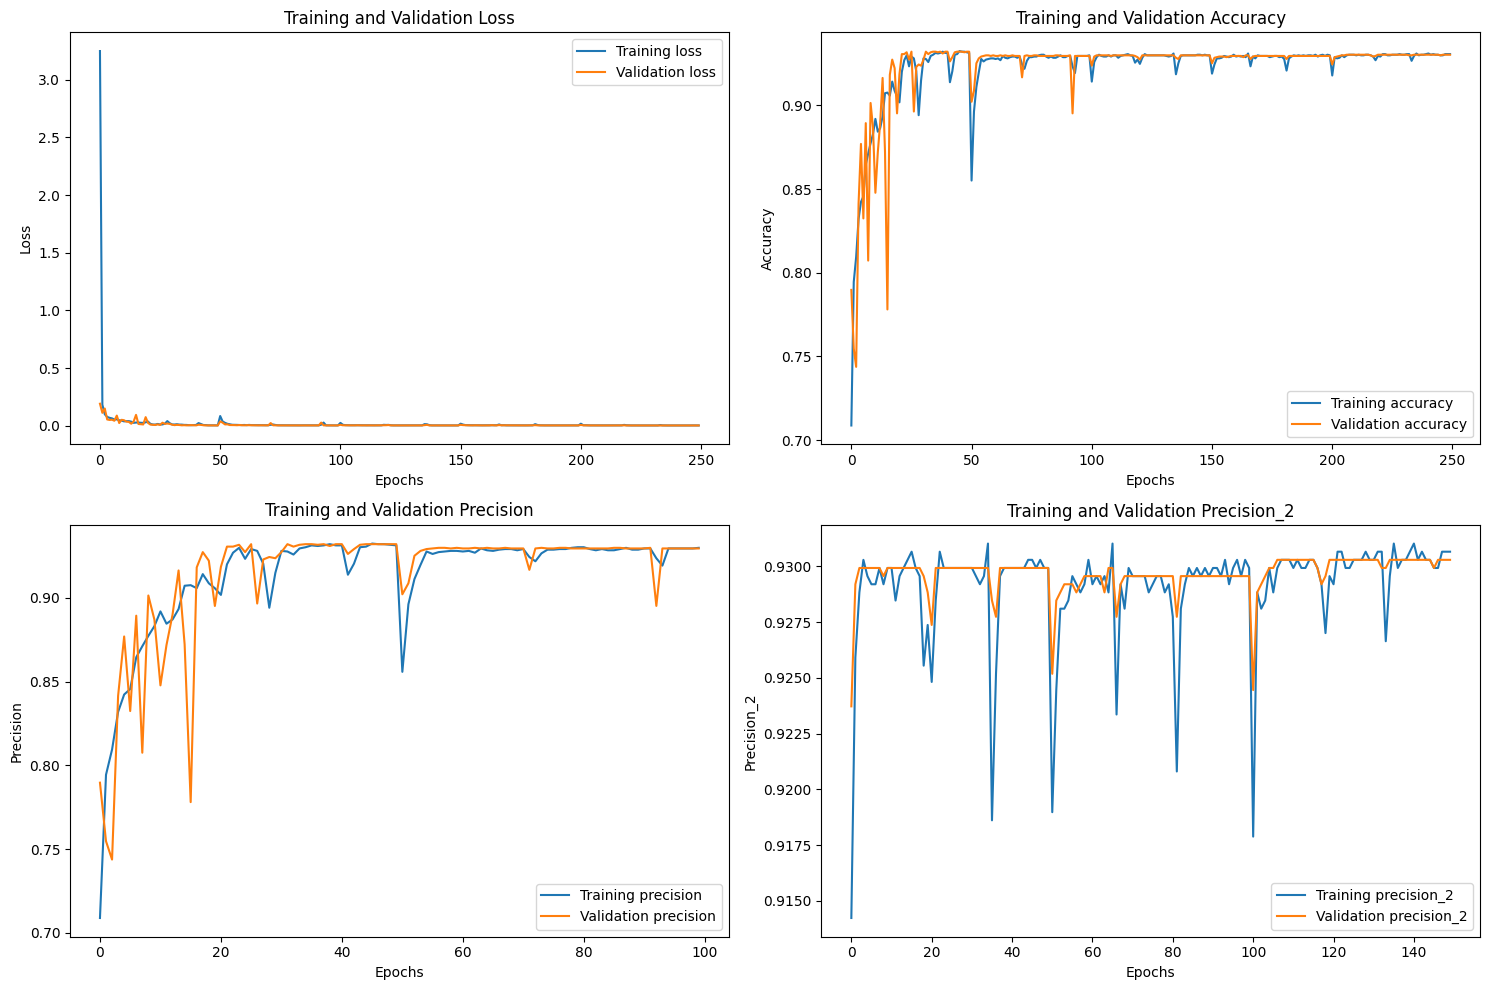

In [8]:
file_path = "Validación cruzada/combined_history.pkl"
with open(file_path, 'rb') as file:
        history = pickle.load(file)

plot_combined_history(history)

In [5]:
model_dir = 'Validación cruzada'
test_data_dir = 'E:/Numpys/Array/TodasBenignMalignant/Validacion_Cruzada_299/Test'

# Suponiendo que MedicalImageDataGenerator y model están definidos en el entorno
test_generator = MedicalImageDataGenerator(test_data_dir, indices=None, batch_size=10, shuffle=False)

# Diccionarios para almacenar los resultados
loss_results = {}
accuracy_results = {}
precision_results = {}

for fold in range(1, 6):
    model_paths = [
        os.path.join(model_dir, f'model_fold_{fold}_50_epochs.keras'),
        os.path.join(model_dir, f'best_model{fold}.keras')
    ]
    for model_path in model_paths:
        print(f"Evaluando modelo {model_path}:")
        model.load_weights(model_path)

        test_metrics = model.evaluate(test_generator, steps=len(test_generator))
        print(f"Resultados del modelo {model_path}: {test_metrics}")
        
        # Suponiendo que test_metrics contiene [loss, accuracy, precision, ...]
        model_name = os.path.basename(model_path)
        loss_results[model_name] = test_metrics[0]
        accuracy_results[model_name] = test_metrics[1]
        precision_results[model_name] = test_metrics[2]

print("Evaluación completada.")

Evaluando modelo Validación cruzada\model_fold_1_50_epochs.keras:
85/85 [==============================] - 21s 105ms/step - loss: 0.1407 - accuracy: 0.8871 - precision: 0.8871
Resultados del modelo Validación cruzada\model_fold_1_50_epochs.keras: [0.14073064923286438, 0.8870587944984436, 0.8870587944984436]
Evaluando modelo Validación cruzada\best_model1.keras:
85/85 [==============================] - 9s 107ms/step - loss: 0.1340 - accuracy: 0.8765 - precision: 0.8765
Resultados del modelo Validación cruzada\best_model1.keras: [0.13399523496627808, 0.8764705657958984, 0.8764705657958984]
Evaluando modelo Validación cruzada\model_fold_2_50_epochs.keras:
85/85 [==============================] - 9s 107ms/step - loss: 0.0914 - accuracy: 0.8976 - precision: 0.8976
Resultados del modelo Validación cruzada\model_fold_2_50_epochs.keras: [0.09137020260095596, 0.8976470828056335, 0.8976470828056335]
Evaluando modelo Validación cruzada\best_model2.keras:
85/85 [==============================] - 9

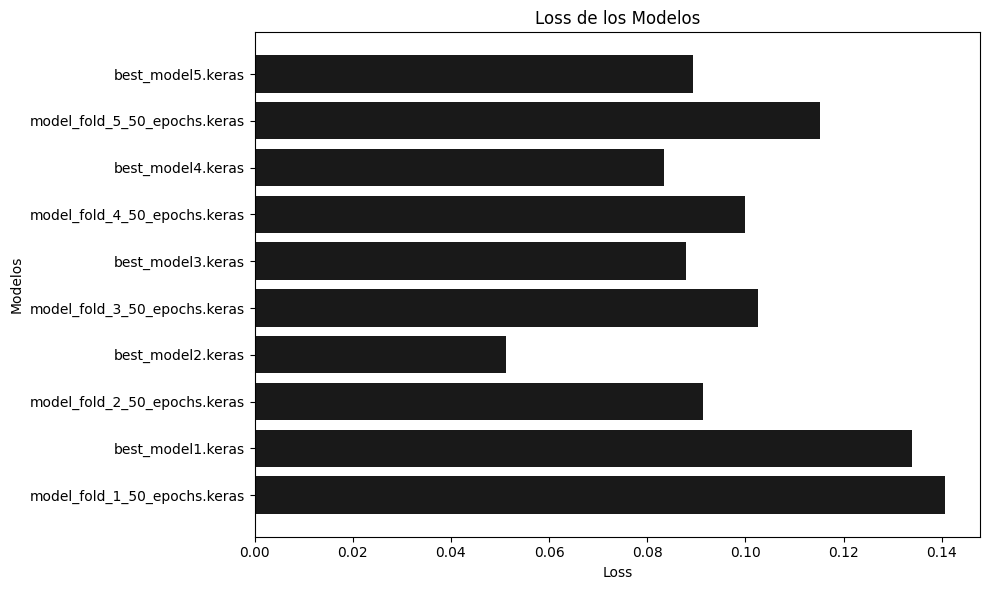

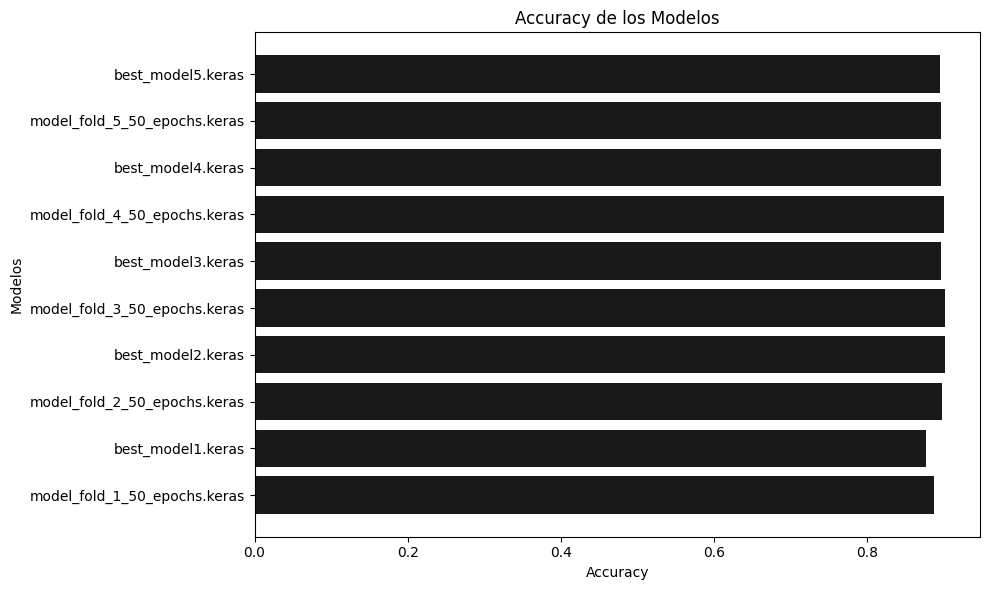

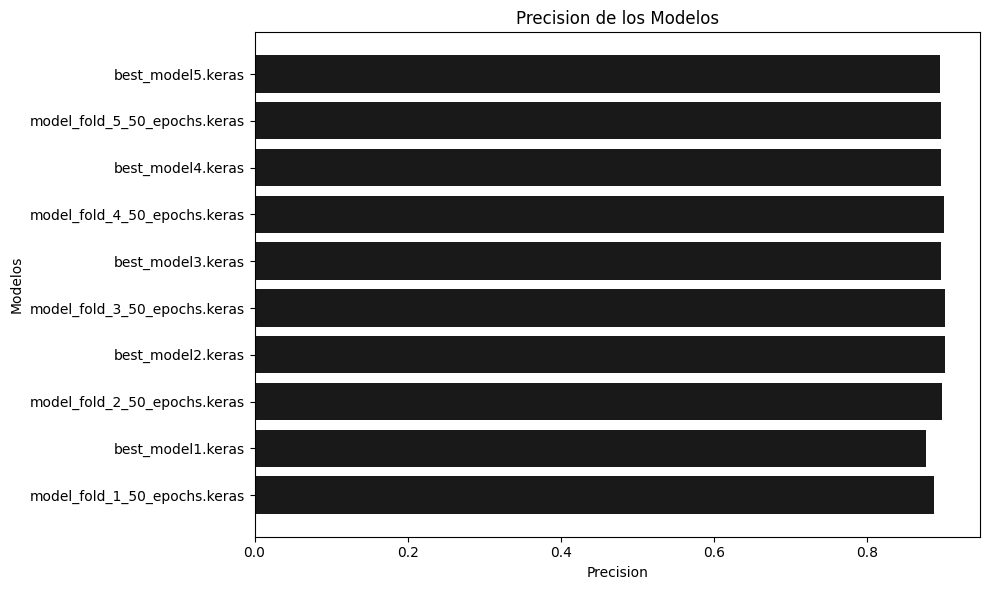

In [6]:
# Función para graficar los resultados
def plot_metrics(metric_dict, metric_name):
    names = list(metric_dict.keys())
    values = list(metric_dict.values())

    plt.figure(figsize=(10, 6))
    plt.barh(names, values, color='#191919')
    plt.ylabel('Modelos')
    plt.xlabel(metric_name)
    plt.title(f'{metric_name} de los Modelos')
    plt.tight_layout()
    plt.show()

# Graficar loss, accuracy y precision
plot_metrics(loss_results, 'Loss')
plot_metrics(accuracy_results, 'Accuracy')
plot_metrics(precision_results, 'Precision')

In [10]:
model.load_weights(os.path.join('Validación cruzada', 'model_fold_3_50_epochs.keras'))

Evaluación de los datos de Testeo:
85/85 [==============================] - 8s 98ms/step


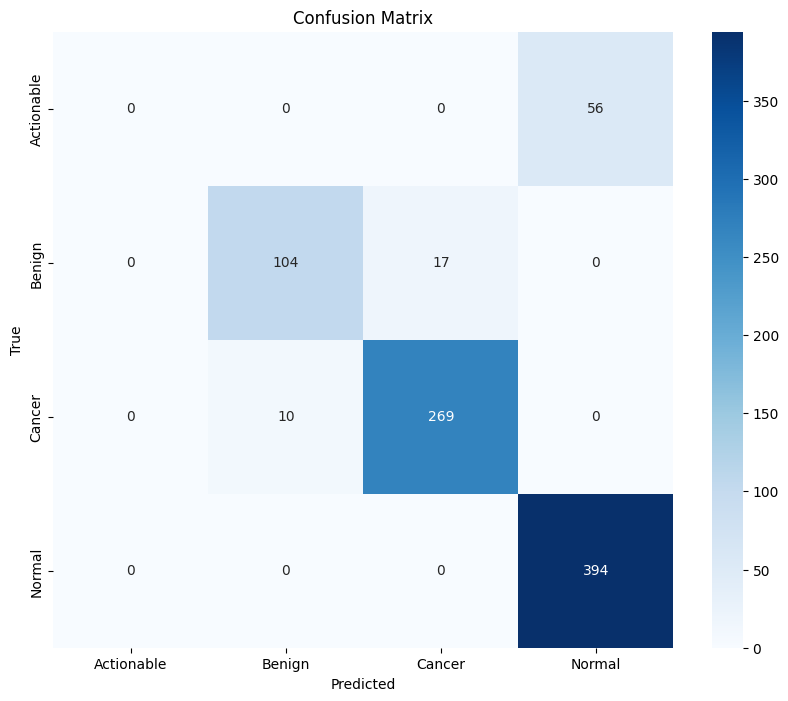

In [11]:
# Matriz de confusión
print("Evaluación de los datos de Testeo:")
test_data_dir = 'E:/Numpys/Array/TodasBenignMalignant/Validacion_Cruzada_299/Test'
test_generator = MedicalImageDataGenerator(test_data_dir, indices=None, batch_size=10, shuffle=False)
test_metrics = model.evaluate(test_generator, steps=len(test_generator))


y_pred_prob = model.predict(test_generator, steps=len(test_generator))
y_pred = np.argmax(y_pred_prob, axis=1)

# Obtener las etiquetas verdaderas del conjunto de prueba
y_true = []
for _, labels in test_generator:
    y_true.extend(labels)
y_true = np.array(y_true)

# Asegurarse de que y_true esté en formato categórico
if len(y_true.shape) > 1 and y_true.shape[1] > 1:
    y_true = np.argmax(y_true, axis=1)

conf_matrix = confusion_matrix(y_true, y_pred)

labels = ['Actionable', 'Benign', 'Cancer', 'Normal']
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

Evaluación de los datos de Testeo:
398/398 [==============================] - 39s 98ms/step


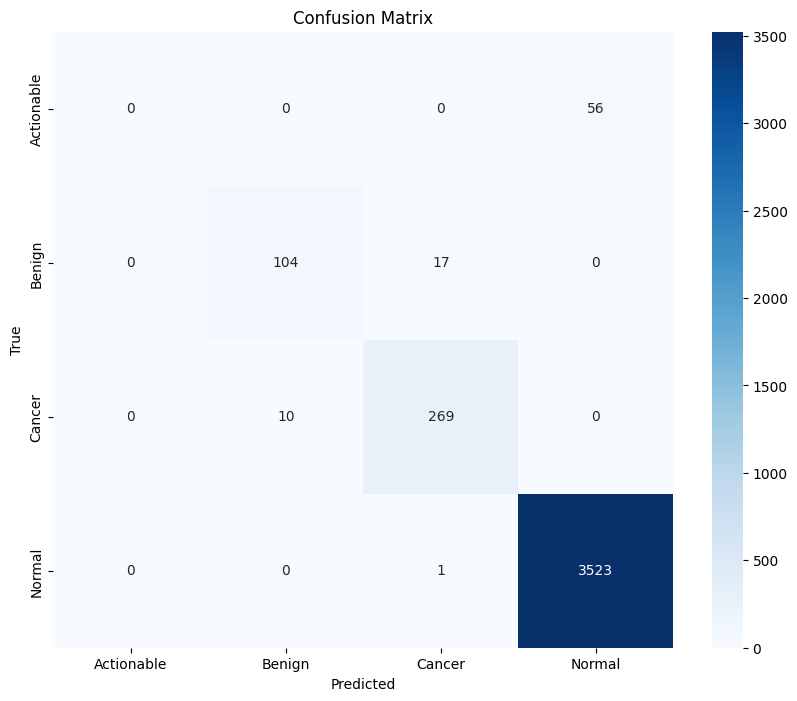

In [12]:
# Matriz de confusión
print("Evaluación de los datos de Testeo:")
test_data_dir = 'E:/Numpys/Array/TodasBenignMalignant/Validacion_Cruzada_299/Test Todas Normales'
test_generator = MedicalImageDataGenerator(test_data_dir, indices=None, batch_size=10, shuffle=False)
test_metrics = model.evaluate(test_generator, steps=len(test_generator))


y_pred_prob = model.predict(test_generator, steps=len(test_generator))
y_pred = np.argmax(y_pred_prob, axis=1)

# Obtener las etiquetas verdaderas del conjunto de prueba
y_true = []
for _, labels in test_generator:
    y_true.extend(labels)
y_true = np.array(y_true)

# Asegurarse de que y_true esté en formato categórico
if len(y_true.shape) > 1 and y_true.shape[1] > 1:
    y_true = np.argmax(y_true, axis=1)

conf_matrix = confusion_matrix(y_true, y_pred)

labels = ['Actionable', 'Benign', 'Cancer', 'Normal']
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [13]:
model.load_weights(os.path.join('Validación cruzada', 'best_model2.keras'))

Evaluación de los datos de Testeo:
85/85 [==============================] - 8s 99ms/step


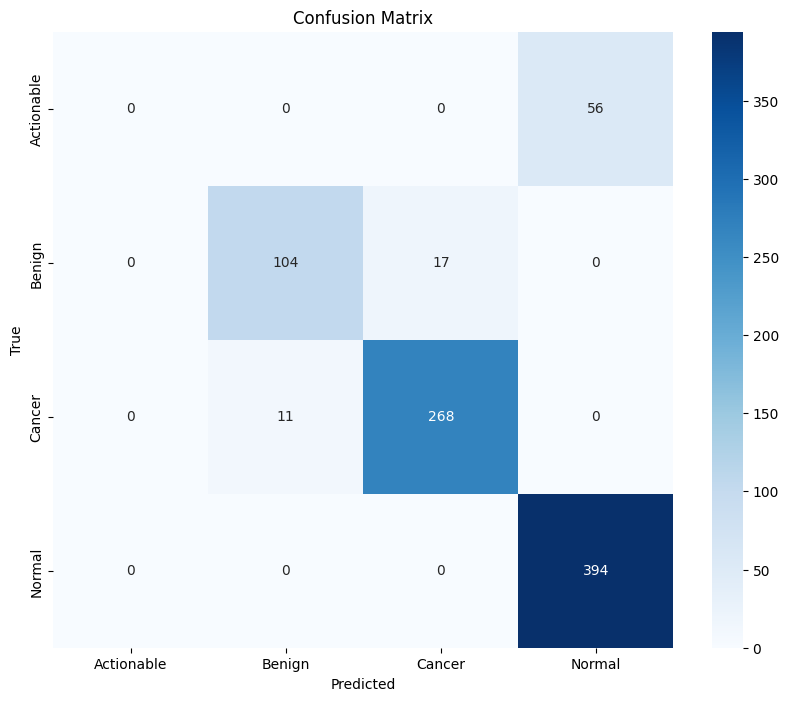

In [14]:
# Matriz de confusión
print("Evaluación de los datos de Testeo:")
test_data_dir = 'E:/Numpys/Array/TodasBenignMalignant/Validacion_Cruzada_299/Test'
test_generator = MedicalImageDataGenerator(test_data_dir, indices=None, batch_size=10, shuffle=False)
test_metrics = model.evaluate(test_generator, steps=len(test_generator))


y_pred_prob = model.predict(test_generator, steps=len(test_generator))
y_pred = np.argmax(y_pred_prob, axis=1)

# Obtener las etiquetas verdaderas del conjunto de prueba
y_true = []
for _, labels in test_generator:
    y_true.extend(labels)
y_true = np.array(y_true)

# Asegurarse de que y_true esté en formato categórico
if len(y_true.shape) > 1 and y_true.shape[1] > 1:
    y_true = np.argmax(y_true, axis=1)

conf_matrix = confusion_matrix(y_true, y_pred)

labels = ['Actionable', 'Benign', 'Cancer', 'Normal']
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

Evaluación de los datos de Testeo:
398/398 [==============================] - 40s 99ms/step


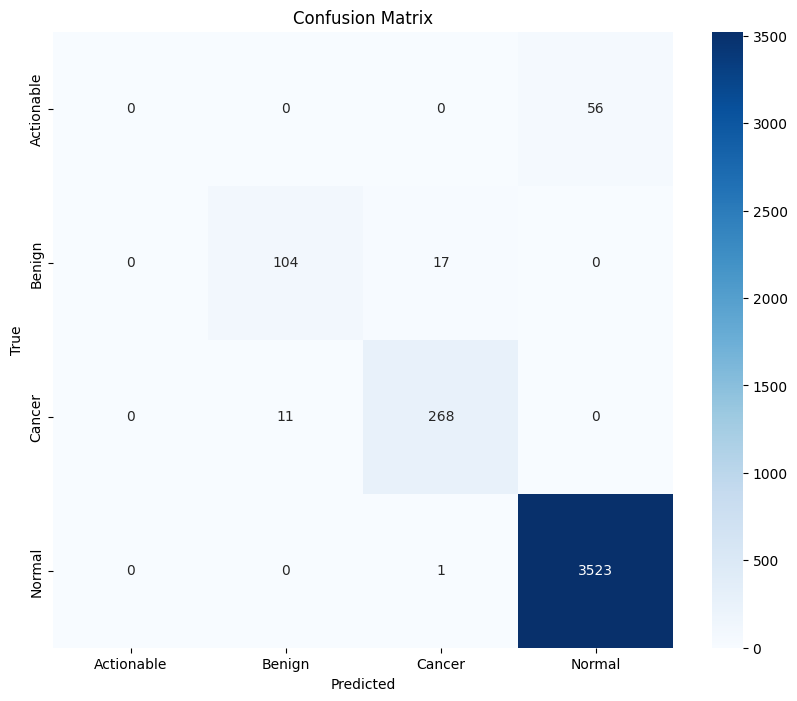

In [15]:
# Matriz de confusión
print("Evaluación de los datos de Testeo:")
test_data_dir = 'E:/Numpys/Array/TodasBenignMalignant/Validacion_Cruzada_299/Test Todas Normales'
test_generator = MedicalImageDataGenerator(test_data_dir, indices=None, batch_size=10, shuffle=False)
test_metrics = model.evaluate(test_generator, steps=len(test_generator))


y_pred_prob = model.predict(test_generator, steps=len(test_generator))
y_pred = np.argmax(y_pred_prob, axis=1)

# Obtener las etiquetas verdaderas del conjunto de prueba
y_true = []
for _, labels in test_generator:
    y_true.extend(labels)
y_true = np.array(y_true)

# Asegurarse de que y_true esté en formato categórico
if len(y_true.shape) > 1 and y_true.shape[1] > 1:
    y_true = np.argmax(y_true, axis=1)

conf_matrix = confusion_matrix(y_true, y_pred)

labels = ['Actionable', 'Benign', 'Cancer', 'Normal']
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Validacion Cruzada DA

In [4]:
# Entrenar el modelo
for fold in range(1, 6):
    print(f"Training fold {fold}/5")
    train_data_dir = f'E:/Numpys/Array/TodasBenignMalignant/Validacion_Cruzada_DA_299/Fold_{fold}/Training'
    val_data_dir =   f'E:/Numpys/Array/TodasBenignMalignant/Validacion_Cruzada_DA_299/Fold_{fold}/Validation'

    train_generator = MedicalImageDataGenerator(train_data_dir, indices=None, batch_size=10)
    val_generator = MedicalImageDataGenerator(train_data_dir, indices=None, batch_size=10, shuffle=False)

    checkpoint_filepath = f'Validación cruzada DA/best_model{fold}.keras'
    model_checkpoint_callback = ModelCheckpoint(
        filepath=checkpoint_filepath,
        save_weights_only=False,
        monitor='val_accuracy',
        mode='max',
        save_best_only=True
    )
    
    history = model.fit(train_generator,
                        validation_data=val_generator,
                        epochs=50,
                        steps_per_epoch=len(train_generator),
                        validation_steps=len(val_generator),
                        callbacks=[model_checkpoint_callback])
    model.save(f"Validación cruzada DA/model_fold_{fold}_50_epochs.keras")
    with open(f"Validación cruzada DA/model_fold_{fold}_50_epochs.pkl", 'wb') as file:
        pickle.dump(history.history, file)

Training fold 1/5
Epoch 1/50
352/352 [==============================] - 106s 247ms/step - loss: 3.8404 - accuracy: 0.7472 - precision: 0.7474 - val_loss: 0.5117 - val_accuracy: 0.8239 - val_precision: 0.8239
Epoch 2/50
352/352 [==============================] - 73s 206ms/step - loss: 0.2205 - accuracy: 0.8148 - precision: 0.8148 - val_loss: 0.1077 - val_accuracy: 0.8173 - val_precision: 0.8173
Epoch 3/50
352/352 [==============================] - 79s 225ms/step - loss: 0.0887 - accuracy: 0.8335 - precision: 0.8338 - val_loss: 0.0635 - val_accuracy: 0.8517 - val_precision: 0.8517
Epoch 4/50
352/352 [==============================] - 73s 207ms/step - loss: 0.0744 - accuracy: 0.8463 - precision: 0.8463 - val_loss: 0.0699 - val_accuracy: 0.8517 - val_precision: 0.8517
Epoch 5/50
352/352 [==============================] - 73s 206ms/step - loss: 0.0685 - accuracy: 0.8557 - precision: 0.8557 - val_loss: 0.0718 - val_accuracy: 0.8276 - val_precision: 0.8276
Epoch 6/50
352/352 [================

Evaluación de los datos de Testeo:
85/85 [==============================] - 14s 99ms/step


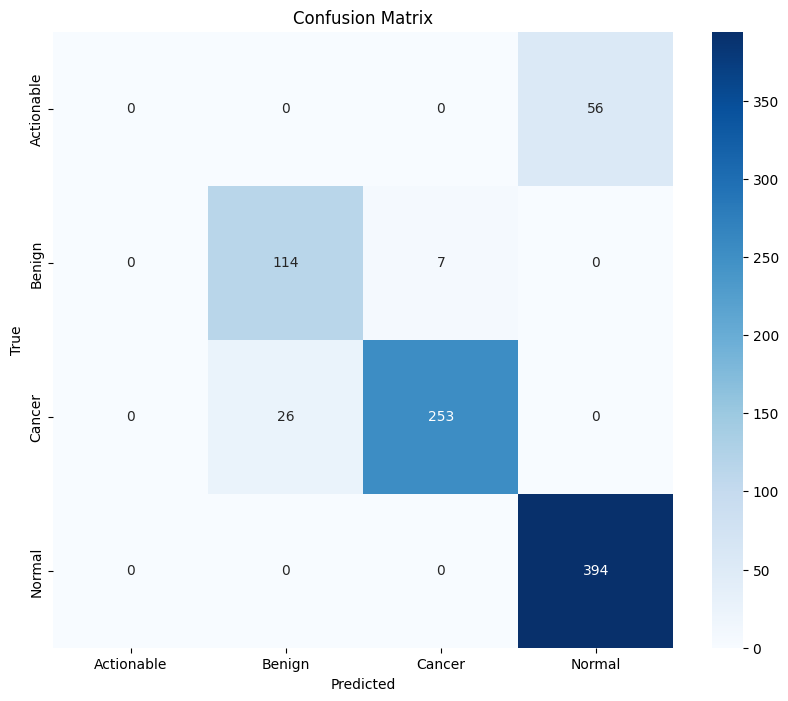

In [5]:
# Matriz de confusión
print("Evaluación de los datos de Testeo:")
test_data_dir = 'E:/Numpys/Array/TodasBenignMalignant/Validacion_Cruzada_299/Test'
test_generator = MedicalImageDataGenerator(test_data_dir, indices=None, batch_size=10, shuffle=False)
test_metrics = model.evaluate(test_generator, steps=len(test_generator))


y_pred_prob = model.predict(test_generator, steps=len(test_generator))
y_pred = np.argmax(y_pred_prob, axis=1)

# Obtener las etiquetas verdaderas del conjunto de prueba
y_true = []
for _, labels in test_generator:
    y_true.extend(labels)
y_true = np.array(y_true)

# Asegurarse de que y_true esté en formato categórico
if len(y_true.shape) > 1 and y_true.shape[1] > 1:
    y_true = np.argmax(y_true, axis=1)


conf_matrix = confusion_matrix(y_true, y_pred)

labels = ['Actionable', 'Benign', 'Cancer', 'Normal']
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [9]:
# Definir la ruta donde se encuentran los archivos .pkl
history_dir = 'Validación cruzada DA'
combined_history = {}

# Función para combinar los historiales
def combine_histories(histories):
    combined = {}
    for history in histories:
        for key, values in history.items():
            if key not in combined:
                combined[key] = []
            combined[key].extend(values)
    return combined

# Cargar los archivos .pkl
histories = []
for fold in range(1, 6):
    file_path = os.path.join(history_dir, f'model_fold_{fold}_50_epochs.pkl')
    with open(file_path, 'rb') as file:
        history = pickle.load(file)
        histories.append(history)

# Combinar los historiales
combined_history = combine_histories(histories)

# Guardar el historial combinado en un nuevo archivo .pkl
with open(os.path.join(history_dir, 'combined_history.pkl'), 'wb') as file:
    pickle.dump(combined_history, file)

print("Historiales combinados y guardados en 'Validación cruzada DA/combined_history.pkl'")

Historiales combinados y guardados en 'Validación cruzada DA/combined_history.pkl'


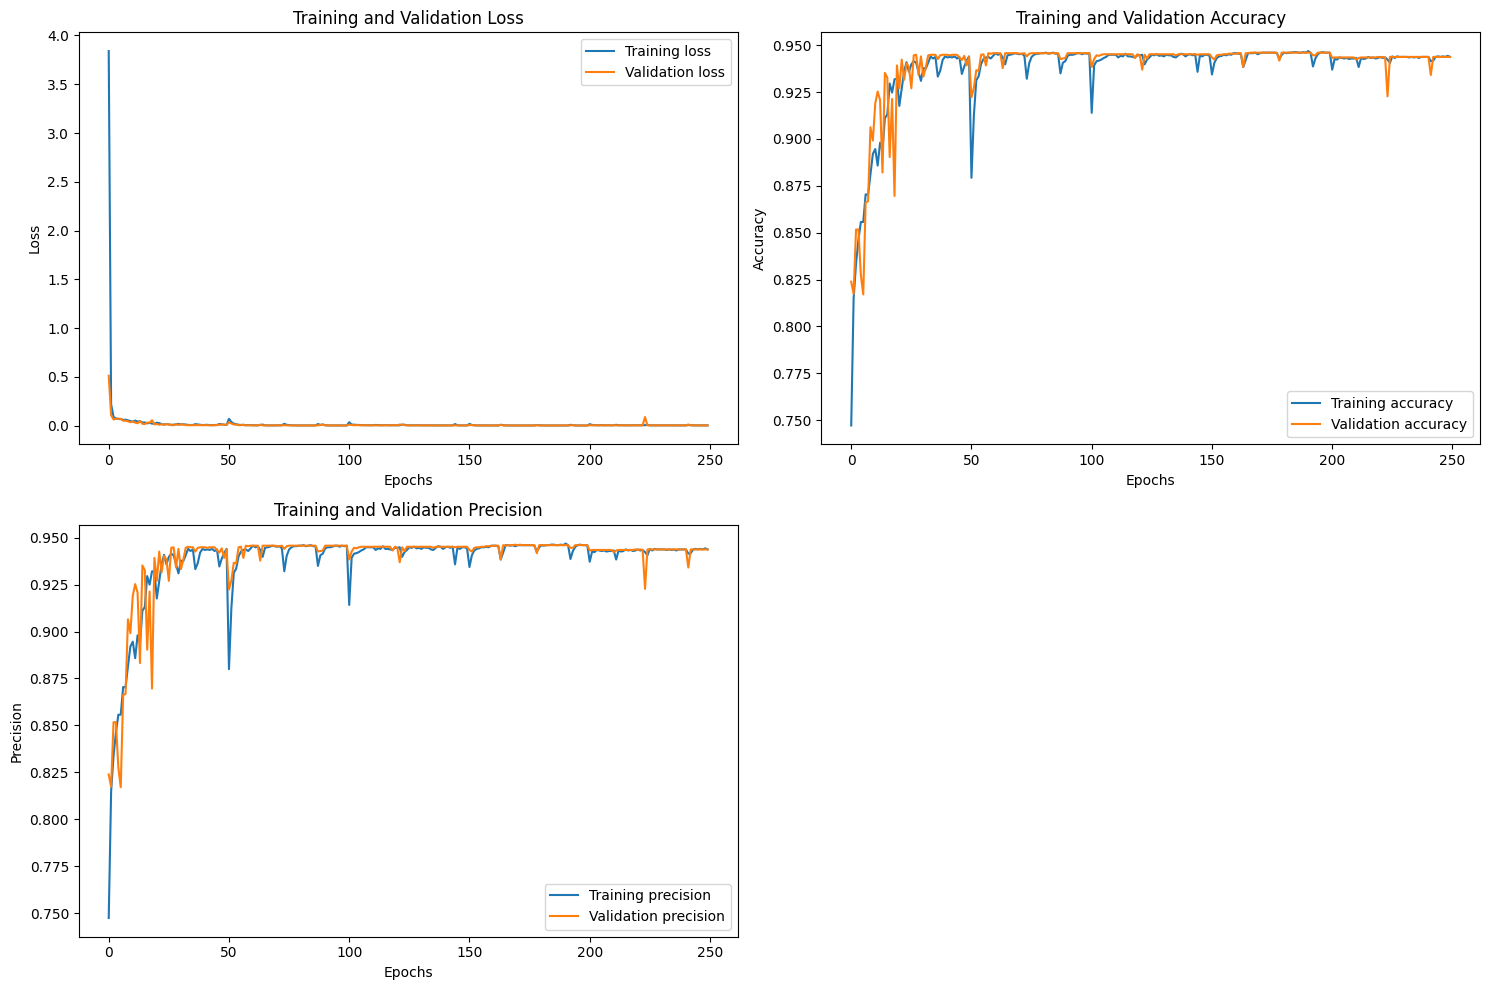

In [10]:
file_path = "Validación cruzada DA/combined_history.pkl"
with open(file_path, 'rb') as file:
        history = pickle.load(file)

plot_combined_history(history)

In [7]:
model_dir = 'Validación cruzada DA'
test_data_dir = 'E:/Numpys/Array/TodasBenignMalignant/Validacion_Cruzada_DA_299/Test'

# Suponiendo que MedicalImageDataGenerator y model están definidos en el entorno
test_generator = MedicalImageDataGenerator(test_data_dir, indices=None, batch_size=10, shuffle=False)

# Diccionarios para almacenar los resultados
loss_results = {}
accuracy_results = {}
precision_results = {}

for fold in range(1, 6):
    model_paths = [
        os.path.join(model_dir, f'model_fold_{fold}_50_epochs.keras'),
        os.path.join(model_dir, f'best_model{fold}.keras')
    ]
    for model_path in model_paths:
        print(f"Evaluando modelo {model_path}:")
        model.load_weights(model_path)

        test_metrics = model.evaluate(test_generator, steps=len(test_generator))
        print(f"Resultados del modelo {model_path}: {test_metrics}")
        
        # Suponiendo que test_metrics contiene [loss, accuracy, precision, ...]
        model_name = os.path.basename(model_path)
        loss_results[model_name] = test_metrics[0]
        accuracy_results[model_name] = test_metrics[1]
        precision_results[model_name] = test_metrics[2]

print("Evaluación completada.")

Evaluando modelo Validación cruzada DA\model_fold_1_50_epochs.keras:
109/109 [==============================] - 12s 106ms/step - loss: 0.3532 - accuracy: 0.8092 - precision: 0.8092
Resultados del modelo Validación cruzada DA\model_fold_1_50_epochs.keras: [0.35324567556381226, 0.8091742992401123, 0.8091742992401123]
Evaluando modelo Validación cruzada DA\best_model1.keras:
109/109 [==============================] - 12s 105ms/step - loss: 0.2630 - accuracy: 0.8009 - precision: 0.8009
Resultados del modelo Validación cruzada DA\best_model1.keras: [0.263019859790802, 0.8009174466133118, 0.8009174466133118]
Evaluando modelo Validación cruzada DA\model_fold_2_50_epochs.keras:
109/109 [==============================] - 12s 107ms/step - loss: 0.3598 - accuracy: 0.8110 - precision: 0.8110
Resultados del modelo Validación cruzada DA\model_fold_2_50_epochs.keras: [0.3598068356513977, 0.8110091686248779, 0.8110091686248779]
Evaluando modelo Validación cruzada DA\best_model2.keras:
109/109 [=======

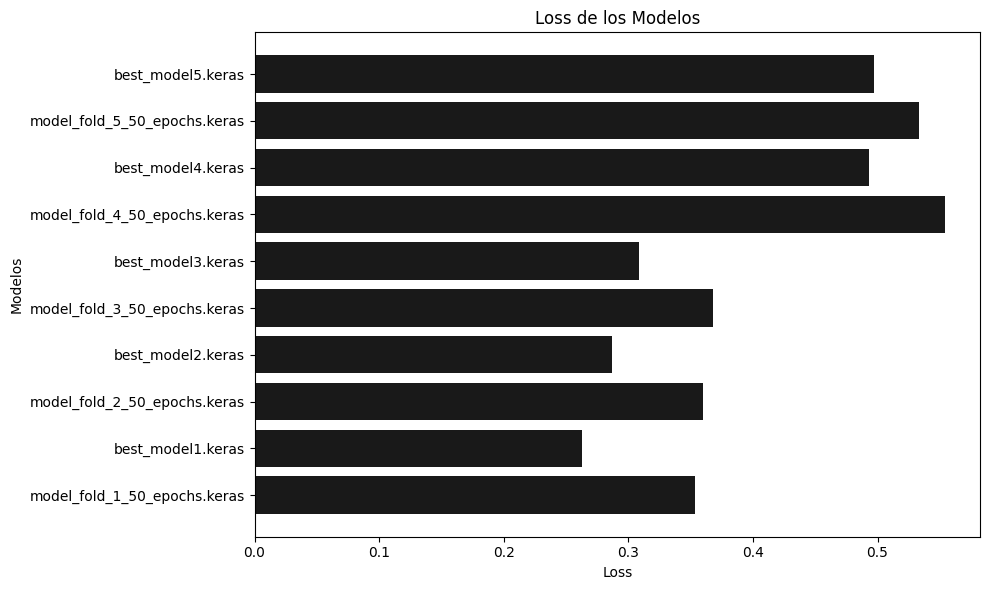

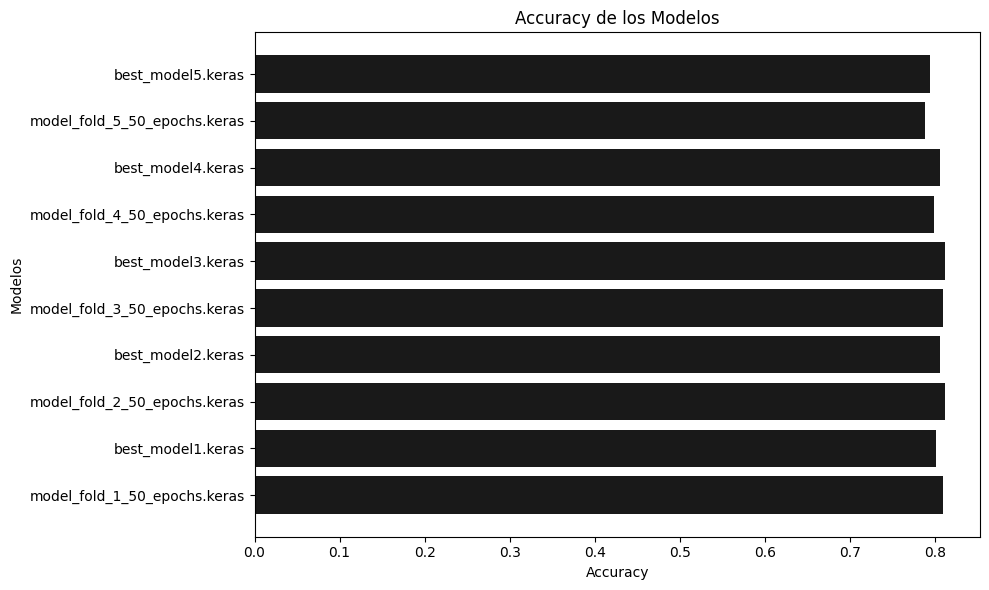

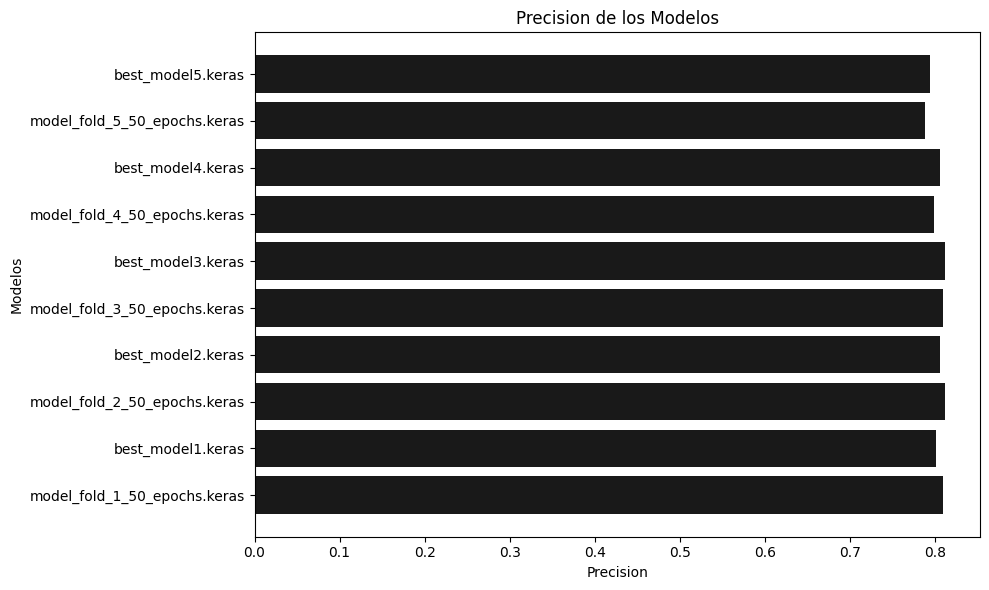

In [8]:
# Función para graficar los resultados
def plot_metrics(metric_dict, metric_name):
    names = list(metric_dict.keys())
    values = list(metric_dict.values())

    plt.figure(figsize=(10, 6))
    plt.barh(names, values, color='#191919')
    plt.ylabel('Modelos')
    plt.xlabel(metric_name)
    plt.title(f'{metric_name} de los Modelos')
    plt.tight_layout()
    plt.show()

# Graficar loss, accuracy y precision
plot_metrics(loss_results, 'Loss')
plot_metrics(accuracy_results, 'Accuracy')
plot_metrics(precision_results, 'Precision')

In [4]:
model.load_weights(os.path.join('Validación cruzada DA', 'best_model3.keras'))

Evaluación de los datos de Testeo:
109/109 [==============================] - 16s 99ms/step


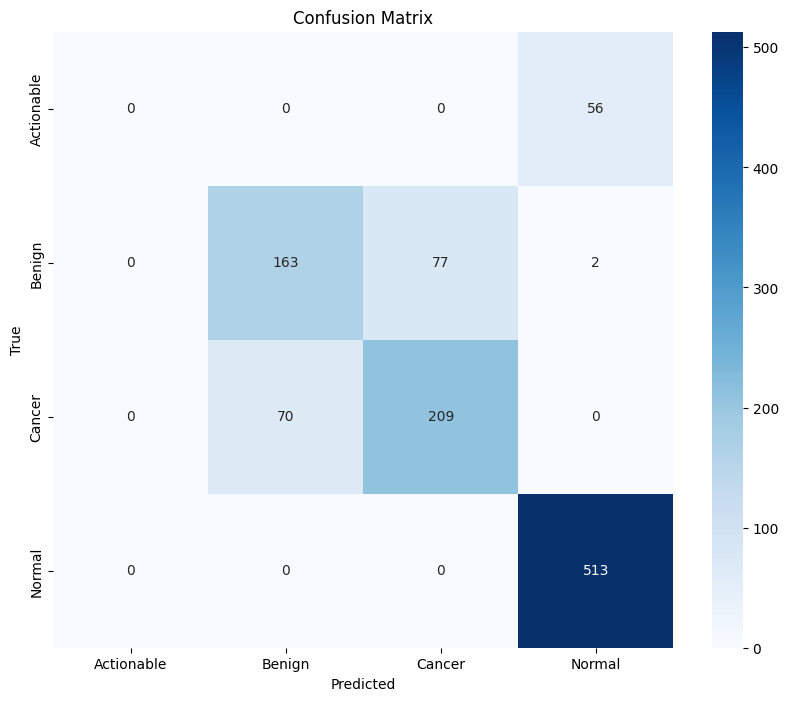

In [5]:
# Matriz de confusión
print("Evaluación de los datos de Testeo:")
test_data_dir = 'E:/Numpys/Array/TodasBenignMalignant/Validacion_Cruzada_DA_299/Test'
test_generator = MedicalImageDataGenerator(test_data_dir, indices=None, batch_size=10, shuffle=False)
test_metrics = model.evaluate(test_generator, steps=len(test_generator))


y_pred_prob = model.predict(test_generator, steps=len(test_generator))
y_pred = np.argmax(y_pred_prob, axis=1)

# Obtener las etiquetas verdaderas del conjunto de prueba
y_true = []
for _, labels in test_generator:
    y_true.extend(labels)
y_true = np.array(y_true)

# Asegurarse de que y_true esté en formato categórico
if len(y_true.shape) > 1 and y_true.shape[1] > 1:
    y_true = np.argmax(y_true, axis=1)

conf_matrix = confusion_matrix(y_true, y_pred)

labels = ['Actionable', 'Benign', 'Cancer', 'Normal']
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

Evaluación de los datos de Testeo:
361/361 [==============================] - 36s 99ms/step


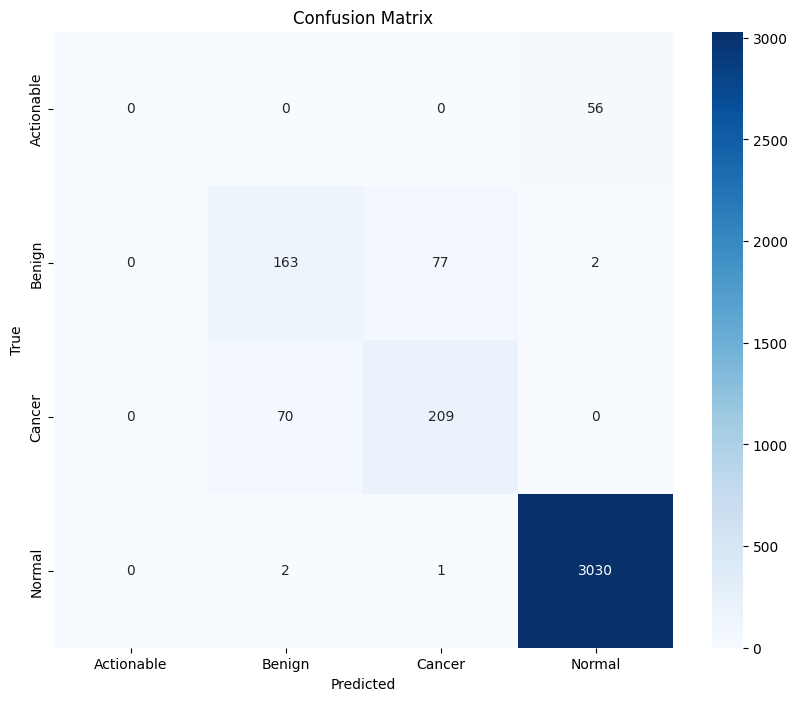

In [6]:
# Matriz de confusión
print("Evaluación de los datos de Testeo:")
test_data_dir = 'E:/Numpys/Array/TodasBenignMalignant/Validacion_Cruzada_DA_299/TestTodasNormales'
test_generator = MedicalImageDataGenerator(test_data_dir, indices=None, batch_size=10, shuffle=False)
test_metrics = model.evaluate(test_generator, steps=len(test_generator))


y_pred_prob = model.predict(test_generator, steps=len(test_generator))
y_pred = np.argmax(y_pred_prob, axis=1)

# Obtener las etiquetas verdaderas del conjunto de prueba
y_true = []
for _, labels in test_generator:
    y_true.extend(labels)
    
y_true = np.array(y_true)

# Asegurarse de que y_true esté en formato categórico
if len(y_true.shape) > 1 and y_true.shape[1] > 1:
    y_true = np.argmax(y_true, axis=1)

conf_matrix = confusion_matrix(y_true, y_pred)

labels = ['Actionable', 'Benign', 'Cancer', 'Normal']
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [7]:
model.load_weights(os.path.join('Validación cruzada DA', 'model_fold_1_50_epochs.keras'))

Evaluación de los datos de Testeo:
109/109 [==============================] - 11s 98ms/step


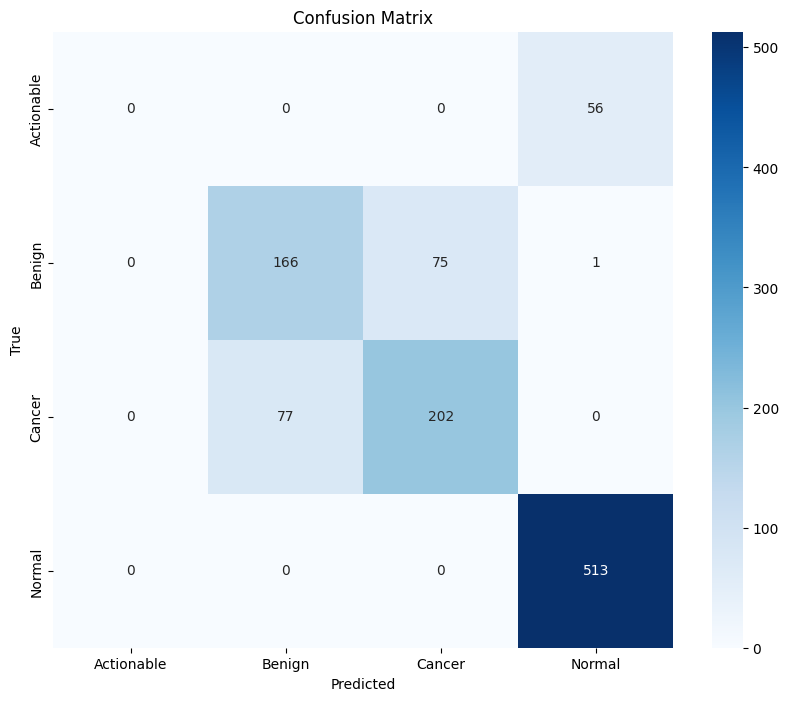

In [8]:
# Matriz de confusión
print("Evaluación de los datos de Testeo:")
test_data_dir = 'E:/Numpys/Array/TodasBenignMalignant/Validacion_Cruzada_DA_299/Test'
test_generator = MedicalImageDataGenerator(test_data_dir, indices=None, batch_size=10, shuffle=False)
test_metrics = model.evaluate(test_generator, steps=len(test_generator))


y_pred_prob = model.predict(test_generator, steps=len(test_generator))
y_pred = np.argmax(y_pred_prob, axis=1)

# Obtener las etiquetas verdaderas del conjunto de prueba
y_true = []
for _, labels in test_generator:
    y_true.extend(labels)
y_true = np.array(y_true)

# Asegurarse de que y_true esté en formato categórico
if len(y_true.shape) > 1 and y_true.shape[1] > 1:
    y_true = np.argmax(y_true, axis=1)

conf_matrix = confusion_matrix(y_true, y_pred)

labels = ['Actionable', 'Benign', 'Cancer', 'Normal']
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

Evaluación de los datos de Testeo:
361/361 [==============================] - 36s 99ms/step


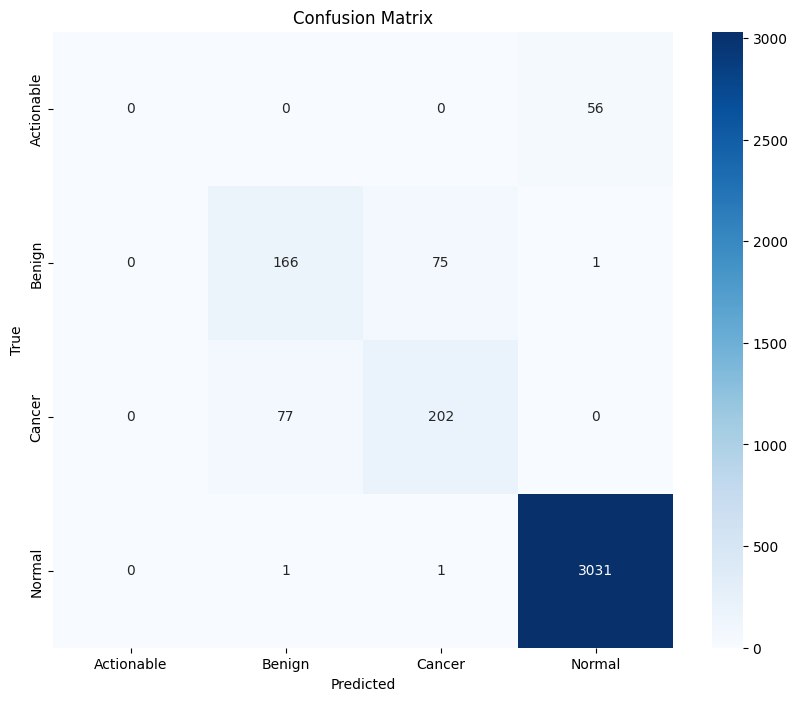

In [9]:
# Matriz de confusión
print("Evaluación de los datos de Testeo:")
test_data_dir = 'E:/Numpys/Array/TodasBenignMalignant/Validacion_Cruzada_DA_299/TestTodasNormales'
test_generator = MedicalImageDataGenerator(test_data_dir, indices=None, batch_size=10, shuffle=False)
test_metrics = model.evaluate(test_generator, steps=len(test_generator))


y_pred_prob = model.predict(test_generator, steps=len(test_generator))
y_pred = np.argmax(y_pred_prob, axis=1)

# Obtener las etiquetas verdaderas del conjunto de prueba
y_true = []
for _, labels in test_generator:
    y_true.extend(labels)
y_true = np.array(y_true)

# Asegurarse de que y_true esté en formato categórico
if len(y_true.shape) > 1 and y_true.shape[1] > 1:
    y_true = np.argmax(y_true, axis=1)

conf_matrix = confusion_matrix(y_true, y_pred)

labels = ['Actionable', 'Benign', 'Cancer', 'Normal']
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Pruebas anteriores a la version definitiva

In [ ]:
# Uso del modelo SIMPLE
train_data_dir = 'E:/Numpys/Array/Bloques/Division/Training'
val_data_dir = 'E:/Numpys/Array/Bloques/Division/Validation'
test_data_dir = 'E:/Numpys/Array/Bloques/Division/Test'

labels = ['Actionable', 'Benign', 'Cancer', 'Normal']
batch_size = 12

# Se asume que MedicalImageDataGenerator está definido e implementado
train_generator = MedicalImageDataGenerator(train_data_dir, batch_size=batch_size)
val_generator = MedicalImageDataGenerator(val_data_dir, batch_size=batch_size, shuffle=False)
test_generator = MedicalImageDataGenerator(test_data_dir, batch_size=batch_size, shuffle=False)

n_classes = 4

# Crear una función de envoltura para convertir las etiquetas a one-hot encoding
def convert_to_one_hot(generator, num_classes):
    while True:
        for batch_images, batch_labels in generator:
            batch_labels_one_hot = tf.keras.utils.to_categorical(batch_labels, num_classes=num_classes)
            yield batch_images, batch_labels_one_hot

train_generator_one_hot = convert_to_one_hot(train_generator, n_classes)
val_generator_one_hot = convert_to_one_hot(val_generator, n_classes)
test_generator_one_hot = convert_to_one_hot(test_generator, n_classes)

checkpoint_filepath = 'best_model_DBT_OriginalBORRAR.h5'
model_checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=False,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True
)

history = model.fit(train_generator_one_hot,
                    validation_data=val_generator_one_hot,
                    epochs=100,
                    steps_per_epoch=len(train_generator),
                    validation_steps=len(val_generator),
                    callbacks=[model_checkpoint_callback])

print("Evaluación de los datos de Testeo:")
test_metrics = model.evaluate(test_generator_one_hot, steps=len(test_generator))

# Mostrar todas las métricas
metric_names = model.metrics_names
for metric_name, metric_value in zip(metric_names, test_metrics):
    print(f"{metric_name}: {metric_value}")

Epoch 1/100
62/62 [==============================] - 73s 854ms/step - loss: 0.2486 - accuracy: 0.4368 - precision: 0.5434 - recall: 0.1935 - auc_roc: 0.6502 - mcc: 0.0000e+00 - val_loss: 0.1905 - val_accuracy: 0.5375 - val_precision: 0.5806 - val_recall: 0.4500 - val_auc_roc: 0.7023 - val_mcc: 0.0000e+00
Epoch 2/100
62/62 [==============================] - 45s 726ms/step - loss: 0.1707 - accuracy: 0.5538 - precision: 0.5786 - recall: 0.4798 - auc_roc: 0.7183 - mcc: 0.0000e+00 - val_loss: 0.1612 - val_accuracy: 0.5375 - val_precision: 0.5613 - val_recall: 0.4958 - val_auc_roc: 0.7166 - val_mcc: 0.0000e+00
Epoch 3/100
62/62 [==============================] - 45s 728ms/step - loss: 0.1485 - accuracy: 0.5551 - precision: 0.5602 - recall: 0.5255 - auc_roc: 0.7336 - mcc: 0.0000e+00 - val_loss: 0.1570 - val_accuracy: 0.5167 - val_precision: 0.5339 - val_recall: 0.4917 - val_auc_roc: 0.7242 - val_mcc: 0.0000e+00
Epoch 4/100
62/62 [==============================] - 45s 728ms/step - loss: 0.1393

In [15]:
history2 = model.fit(train_generator_one_hot,
                    validation_data=val_generator_one_hot,
                    epochs=100,
                    steps_per_epoch=len(train_generator),
                    validation_steps=len(val_generator),
                    callbacks=[model_checkpoint_callback])

Epoch 1/100
62/62 [==============================] - 45s 720ms/step - loss: 1.1646 - accuracy: 0.5847 - precision_1: 0.5841 - recall_1: 0.5833 - auc_roc: 0.8813 - mcc: 0.9918 - val_loss: 1.3525 - val_accuracy: 0.6458 - val_precision_1: 0.6485 - val_recall_1: 0.6458 - val_auc_roc: 0.8981 - val_mcc: 0.9172
Epoch 2/100
62/62 [==============================] - 47s 757ms/step - loss: 1.1658 - accuracy: 0.5833 - precision_1: 0.5841 - recall_1: 0.5833 - auc_roc: 0.8810 - mcc: 0.9917 - val_loss: 1.3619 - val_accuracy: 0.6833 - val_precision_1: 0.6862 - val_recall_1: 0.6833 - val_auc_roc: 0.9056 - val_mcc: 0.9161
Epoch 3/100
62/62 [==============================] - 45s 729ms/step - loss: 1.1657 - accuracy: 0.5806 - precision_1: 0.5801 - recall_1: 0.5793 - auc_roc: 0.8808 - mcc: 0.9917 - val_loss: 1.3334 - val_accuracy: 0.6667 - val_precision_1: 0.6723 - val_recall_1: 0.6667 - val_auc_roc: 0.9036 - val_mcc: 0.9410
Epoch 4/100
62/62 [==============================] - 45s 726ms/step - loss: 1.1610

In [24]:
history3 = model.fit(train_generator_one_hot,
                    validation_data=val_generator_one_hot,
                    epochs=100,
                    steps_per_epoch=len(train_generator),
                    validation_steps=len(val_generator),
                    callbacks=[model_checkpoint_callback])

Epoch 1/100
62/62 [==============================] - 45s 722ms/step - loss: 1.0809 - accuracy: 0.6438 - precision_1: 0.6438 - recall_1: 0.6438 - auc_roc: 0.9035 - mcc: 0.9920 - val_loss: 1.3886 - val_accuracy: 0.6708 - val_precision_1: 0.6736 - val_recall_1: 0.6708 - val_auc_roc: 0.9103 - val_mcc: 0.9135
Epoch 2/100
62/62 [==============================] - 47s 763ms/step - loss: 1.0744 - accuracy: 0.6317 - precision_1: 0.6321 - recall_1: 0.6304 - auc_roc: 0.9027 - mcc: 0.9920 - val_loss: 1.3956 - val_accuracy: 0.6958 - val_precision_1: 0.6987 - val_recall_1: 0.6958 - val_auc_roc: 0.9133 - val_mcc: 0.9441
Epoch 3/100
62/62 [==============================] - 45s 726ms/step - loss: 1.0825 - accuracy: 0.6384 - precision_1: 0.6380 - recall_1: 0.6371 - auc_roc: 0.9034 - mcc: 0.9920 - val_loss: 1.3951 - val_accuracy: 0.6625 - val_precision_1: 0.6653 - val_recall_1: 0.6625 - val_auc_roc: 0.9043 - val_mcc: 0.9135
Epoch 4/100
62/62 [==============================] - 45s 730ms/step - loss: 1.0673

In [34]:
history4 = model.fit(train_generator_one_hot,
                    validation_data=val_generator_one_hot,
                    epochs=100,
                    steps_per_epoch=len(train_generator),
                    validation_steps=len(val_generator),
                    callbacks=[model_checkpoint_callback])

Epoch 1/100
62/62 [==============================] - 45s 727ms/step - loss: 0.9795 - accuracy: 0.6895 - precision_1: 0.6895 - recall_1: 0.6895 - auc_roc: 0.9255 - mcc: 0.9922 - val_loss: 1.7176 - val_accuracy: 0.6917 - val_precision_1: 0.6904 - val_recall_1: 0.6875 - val_auc_roc: 0.9118 - val_mcc: 0.9411
Epoch 2/100
62/62 [==============================] - 45s 736ms/step - loss: 0.9619 - accuracy: 0.7097 - precision_1: 0.7093 - recall_1: 0.7083 - auc_roc: 0.9281 - mcc: 0.9926 - val_loss: 1.7231 - val_accuracy: 0.6833 - val_precision_1: 0.6820 - val_recall_1: 0.6792 - val_auc_roc: 0.9124 - val_mcc: 0.9385
Epoch 3/100
62/62 [==============================] - 45s 736ms/step - loss: 0.9642 - accuracy: 0.6935 - precision_1: 0.6935 - recall_1: 0.6935 - auc_roc: 0.9273 - mcc: 0.9925 - val_loss: 1.6985 - val_accuracy: 0.7000 - val_precision_1: 0.7004 - val_recall_1: 0.6917 - val_auc_roc: 0.9119 - val_mcc: 0.9422
Epoch 4/100
62/62 [==============================] - 45s 731ms/step - loss: 0.9608

KeyboardInterrupt: 

In [4]:
# Uso del modelo SIMPLE
train_data_dir = 'E:/Numpys/Array/Bloques 607 Benign malign/Division/Training'
val_data_dir = 'E:/Numpys/Array/Bloques 607 Benign malign/Division/Validation'
test_data_dir = 'E:/Numpys/Array/Bloques 607 Benign malign/Division/Test'

labels = ['Actionable', 'Benign', 'Cancer', 'Normal']
batch_size = 12

# Se asume que MedicalImageDataGenerator está definido e implementado
train_generator = MedicalImageDataGenerator(train_data_dir, batch_size=batch_size)
val_generator = MedicalImageDataGenerator(val_data_dir, batch_size=batch_size, shuffle=False)
test_generator = MedicalImageDataGenerator(test_data_dir, batch_size=batch_size, shuffle=False)

n_classes = 4

# Crear una función de envoltura para convertir las etiquetas a one-hot encoding
def convert_to_one_hot(generator, num_classes):
    while True:
        for batch_images, batch_labels in generator:
            batch_labels_one_hot = tf.keras.utils.to_categorical(batch_labels, num_classes=num_classes)
            yield batch_images, batch_labels_one_hot

train_generator_one_hot = convert_to_one_hot(train_generator, n_classes)
val_generator_one_hot = convert_to_one_hot(val_generator, n_classes)
test_generator_one_hot = convert_to_one_hot(test_generator, n_classes)

checkpoint_filepath = 'best_model_DBT_DA.h5'
model_checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=False,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True
)

history = model.fit(train_generator_one_hot,
                    validation_data=val_generator_one_hot,
                    epochs=100,
                    steps_per_epoch=len(train_generator),
                    validation_steps=len(val_generator),
                    callbacks=[model_checkpoint_callback])
# Guardar el modelo
path = 'model_Google_100_epoch_DBT_DA.h5'
model.save(path)

history2 = model.fit(train_generator_one_hot,
                    validation_data=val_generator_one_hot,
                    epochs=100,
                    steps_per_epoch=len(train_generator),
                    validation_steps=len(val_generator),
                    callbacks=[model_checkpoint_callback])

# Guardar el modelo
path = 'model_Google_200_epoch_DBT_DA.h5'
model.save(path)

history3 = model.fit(train_generator_one_hot,
                    validation_data=val_generator_one_hot,
                    epochs=100,
                    steps_per_epoch=len(train_generator),
                    validation_steps=len(val_generator),
                    callbacks=[model_checkpoint_callback])

# Guardar el modelo
path = 'model_Google_300_epoch_DBT_DA.h5'
model.save(path)

history4 = model.fit(train_generator_one_hot,
                    validation_data=val_generator_one_hot,
                    epochs=100,
                    steps_per_epoch=len(train_generator),
                    validation_steps=len(val_generator),
                    callbacks=[model_checkpoint_callback])

# Guardar el modelo
path = 'model_Google_400_epoch_DBT_DA.h5'
model.save(path)

print("Evaluación de los datos de Testeo:")
test_metrics = model.evaluate(test_generator_one_hot, steps=len(test_generator))

# Mostrar todas las métricas
metric_names = model.metrics_names
for metric_name, metric_value in zip(metric_names, test_metrics):
    print(f"{metric_name}: {metric_value}")

# Combina los historiales
def combine_histories(*histories):
    combined_history = {}
    for history in histories:
        for key in history.history.keys():
            if key not in combined_history:
                combined_history[key] = history.history[key]
            else:
                combined_history[key] = np.concatenate([combined_history[key], history.history[key]])
    return combined_history

combined_history = combine_histories(history, history2)

# Guardar el objeto history
with open('model_Google_100_epoch_DBT_DA.pkl', 'wb') as file:
    pickle.dump(history, file)
with open('model_Google_200_epoch_DBT_DA.pkl', 'wb') as file:
    pickle.dump(combined_history, file)

def combine_histories(*histories):
    combined_history = {}
    for history in histories:
        for key in history.history.keys():
            if key not in combined_history:
                combined_history[key] = history.history[key]
            else:
                combined_history[key] = np.concatenate([combined_history[key], history.history[key]])
    return combined_history

combined_history = combine_histories(history, history2, history3)

with open('model_Google_300_epoch_DBT_DA.pkl', 'wb') as file:
    pickle.dump(combined_history, file)

def combine_histories(*histories):
    combined_history = {}
    for history in histories:
        for key in history.history.keys():
            if key not in combined_history:
                combined_history[key] = history.history[key]
            else:
                combined_history[key] = np.concatenate([combined_history[key], history.history[key]])
    return combined_history

combined_history = combine_histories(history, history2, history3, history4)
with open('model_Google_400_epoch_DBT_DA.pkl', 'wb') as file:
    pickle.dump(combined_history, file)

Epoch 1/100
124/124 [==============================] - 118s 789ms/step - loss: 0.2284 - accuracy: 0.6008 - precision: 0.6635 - recall: 0.4758 - auc_roc: 0.7987 - mcc: 0.0000e+00 - val_loss: 0.1754 - val_accuracy: 0.6667 - val_precision: 0.6771 - val_recall: 0.6138 - val_auc_roc: 0.8386 - val_mcc: 0.0000e+00
Epoch 2/100
124/124 [==============================] - 93s 747ms/step - loss: 0.1583 - accuracy: 0.6956 - precision: 0.7046 - recall: 0.6734 - auc_roc: 0.8504 - mcc: 0.0000e+00 - val_loss: 0.1243 - val_accuracy: 0.7419 - val_precision: 0.7444 - val_recall: 0.7398 - val_auc_roc: 0.8681 - val_mcc: 0.0000e+00
Epoch 3/100
124/124 [==============================] - 93s 749ms/step - loss: 0.1369 - accuracy: 0.7103 - precision: 0.7129 - recall: 0.7043 - auc_roc: 0.8640 - mcc: 0.0000e+00 - val_loss: 0.1153 - val_accuracy: 0.7480 - val_precision: 0.7490 - val_recall: 0.7459 - val_auc_roc: 0.8750 - val_mcc: 0.0000e+00
Epoch 4/100
124/124 [==============================] - 91s 731ms/step - los

INFO:tensorflow:Assets written to: ram://89fe6f76-b9f4-4c34-ac55-e30c560f9b29/assets


INFO:tensorflow:Assets written to: ram://89fe6f76-b9f4-4c34-ac55-e30c560f9b29/assets


In [7]:
import tensorflow.keras.backend as K

def count_parameters(model):
    trainable_count = np.sum([K.count_params(w) for w in model.trainable_weights])
    non_trainable_count = np.sum([K.count_params(w) for w in model.non_trainable_weights])

    total_count = trainable_count + non_trainable_count

    print(f'Total params: {total_count:,}')
    print(f'Trainable params: {trainable_count:,}')
    print(f'Non-trainable params: {non_trainable_count:,}')

# Utilizar la función count_parameters para el modelo
count_parameters(model)


Total params: 87,480,484
Trainable params: 271,652
Non-trainable params: 87,208,832


In [30]:
# Combina los historiales
def combine_histories(*histories):
    combined_history = {}
    for history in histories:
        for key in history.history.keys():
            if key not in combined_history:
                combined_history[key] = history.history[key]
            else:
                combined_history[key] = np.concatenate([combined_history[key], history.history[key]])
    return combined_history

combined_history = combine_histories(history, history2, history3, history4)

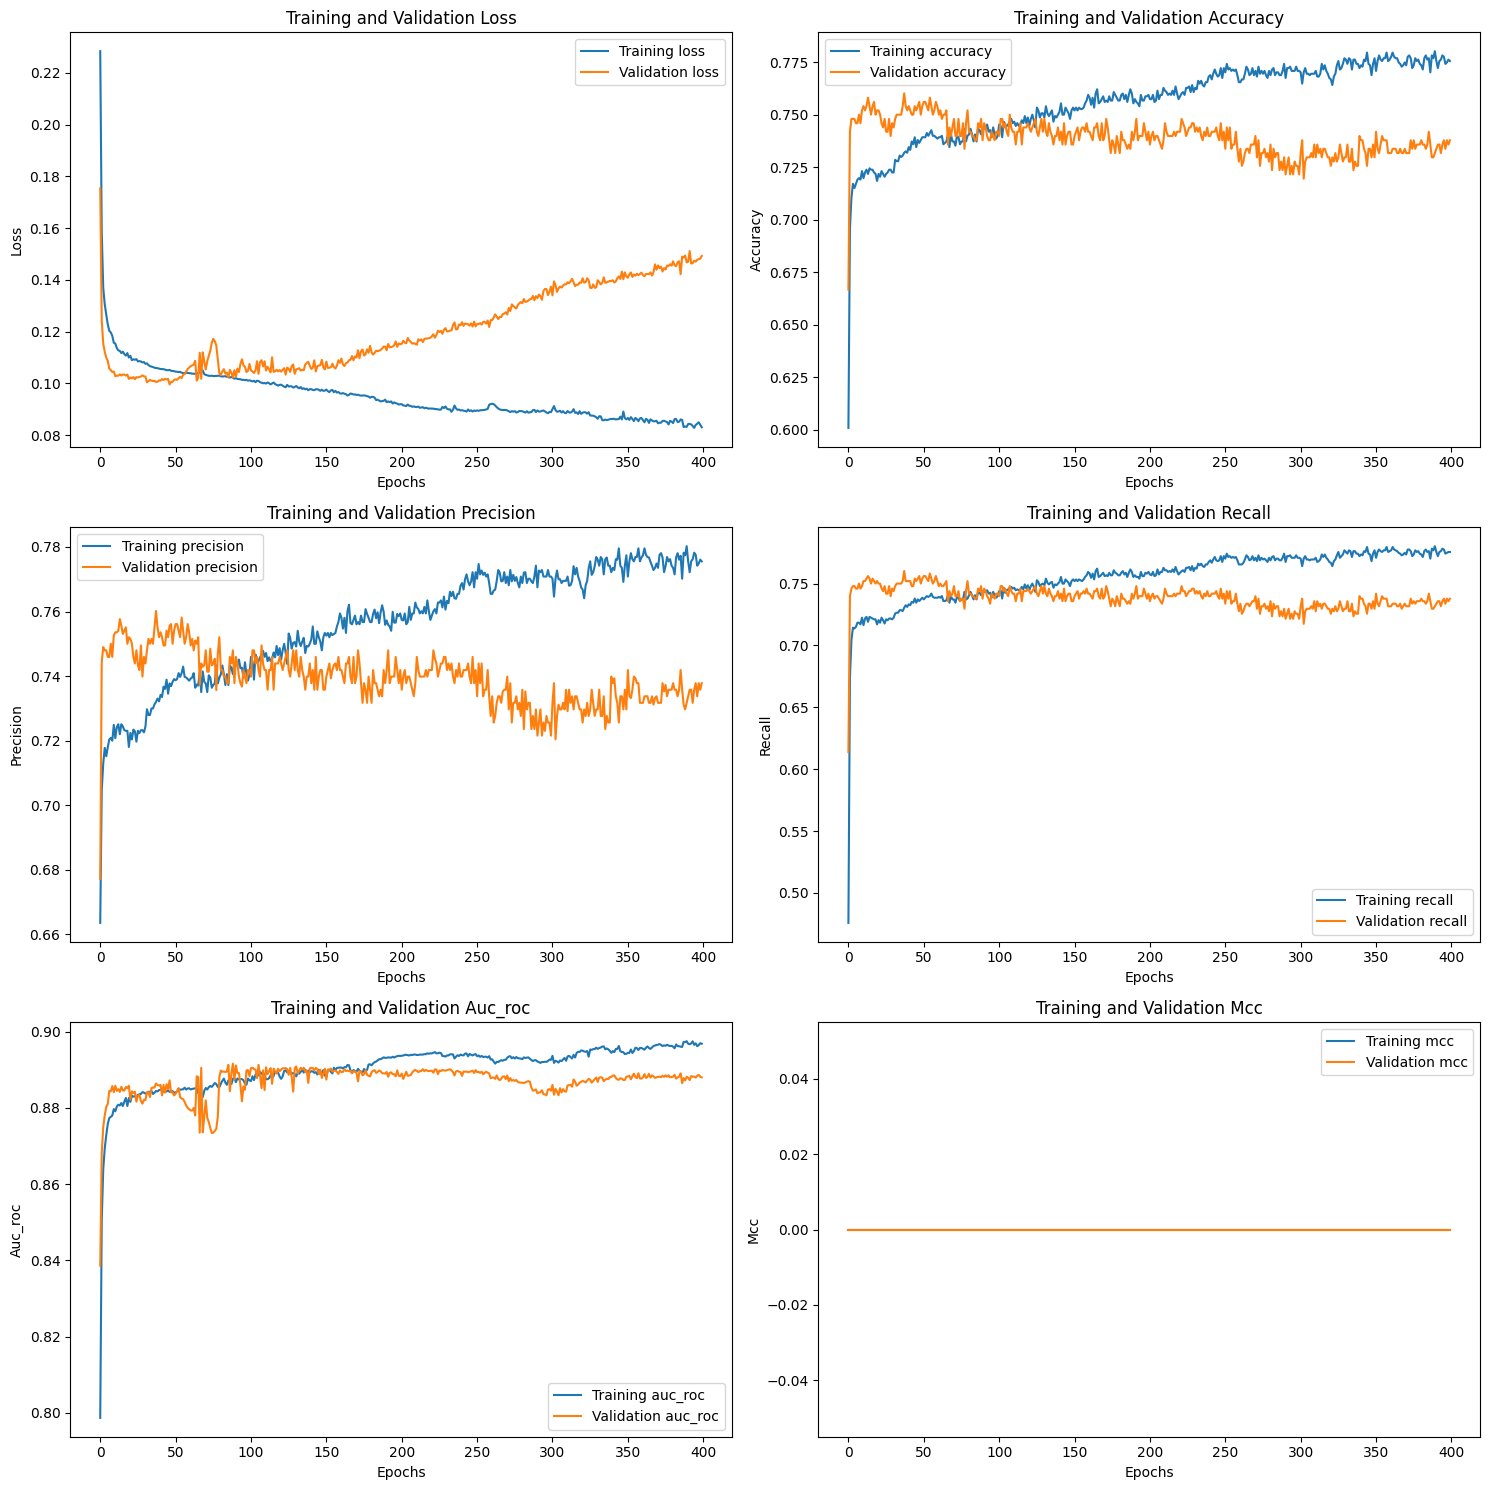

In [6]:
def plot_combined_history(history, columns=2):
    # Verifica si el historial es un objeto 'History' de Keras
    if hasattr(history, 'history'):
        history = history.history
    
    metrics = [key for key in history.keys() if not key.startswith('val_')]
    num_metrics = len(metrics)
    rows = (num_metrics + columns - 1) // columns  # Calcula el número de filas necesarias

    plt.figure(figsize=(15, 5 * rows))
    
    for i, metric in enumerate(metrics):
        plt.subplot(rows, columns, i + 1)
        plt.plot(history[metric], label=f'Training {metric}')
        plt.plot(history[f'val_{metric}'], label=f'Validation {metric}')
        plt.xlabel('Epochs')
        plt.ylabel(metric.capitalize())
        plt.title(f'Training and Validation {metric.capitalize()}')
        plt.legend()

    plt.tight_layout()
    plt.show()

# Puedes usar la función con un solo historial
plot_combined_history(combined_history)

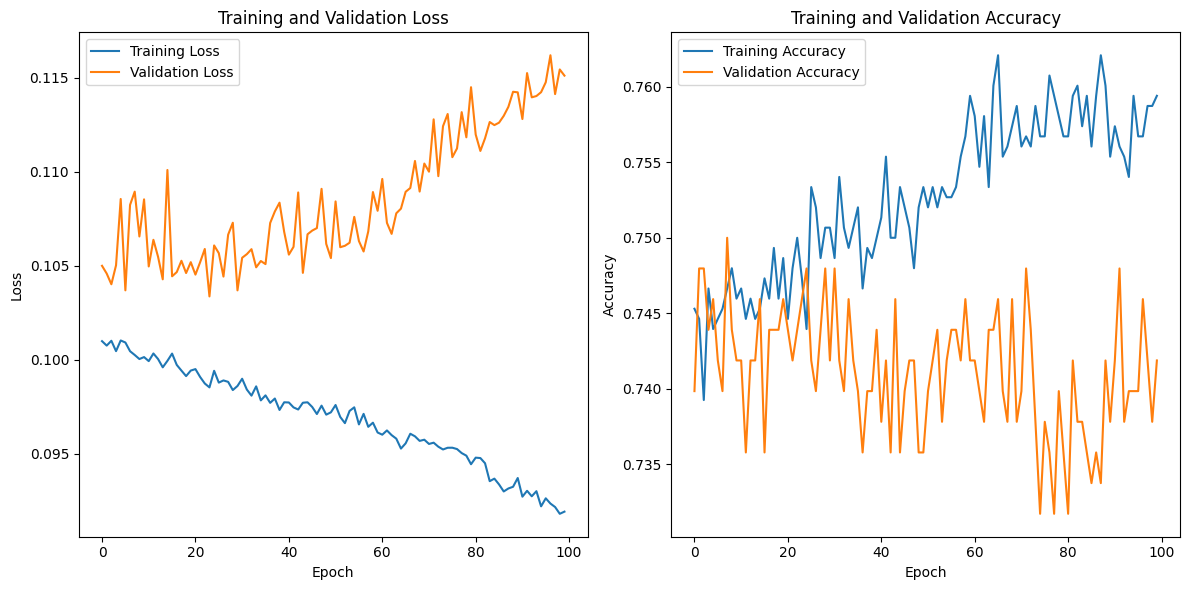

In [9]:
# Obtener las métricas de pérdida y precisión del historial de entrenamiento
train_loss = history2.history['loss']
val_loss = history2.history['val_loss']
train_acc = history2.history['accuracy']
val_acc = history2.history['val_accuracy']

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

Evaluación de los datos de Testeo:
41/41 [==============================] - 27s 537ms/step


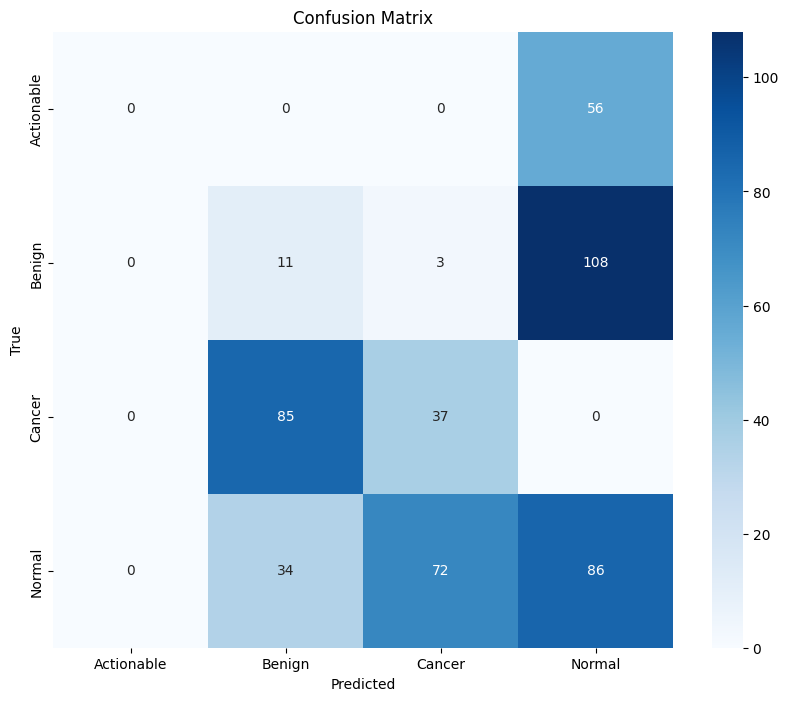

In [8]:
# Matriz de confusión
print("Evaluación de los datos de Testeo:")
test_metrics = model.evaluate(val_generator_one_hot, steps=len(val_generator))


y_pred_prob = model.predict(val_generator_one_hot, steps=len(val_generator))
y_pred = np.argmax(y_pred_prob, axis=1)

# Obtener las etiquetas verdaderas del conjunto de prueba
y_true = []
for _, labels in test_generator:
    y_true.extend(labels)
y_true = np.array(y_true)

# Asegurarse de que y_true esté en formato categórico
if len(y_true.shape) > 1 and y_true.shape[1] > 1:
    y_true = np.argmax(y_true, axis=1)


conf_matrix = confusion_matrix(y_true, y_pred)

labels = ['Actionable', 'Benign', 'Cancer', 'Normal']
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [33]:
# Guardar el modelo
path = 'model_Google_300_epoch_DBT.h5'
model.save(path)
# Guardar el objeto history
with open('model_Google_300_epoch_DBT.pkl', 'wb') as file:
    pickle.dump(combined_history, file)
print(f"El modelo se ha guardado en '{path}'.")

El modelo se ha guardado en 'model_Google_300_epoch_DBT.h5'.


In [ ]:
# Cargar el modelo
path = 'best_model_Google_DA_607.h5'
model = tf.keras.models.load_model(path)
with open('best_model_Google_DA_607.pkl', 'rb') as file:
    history = pickle.load(file)
print(f"El modelo se ha cargado correctamente desde '{path}'.")

In [ ]:
model = tf.keras.models.load_model('best_model.h5')

In [ ]:
# Configuraciones del directorio
train_data_dir = 'E:/Numpys/Array/Bloques 607 Benign malign/DataAugmentation/Training'
val_data_dir = 'E:/Numpys/Array/Bloques 607 Benign malign/DataAugmentation/Validation'
test_data_dir = 'E:/Numpys/Array/Bloques 607 Benign malign/DataAugmentation/Test'

# Etiquetas y generadores de datos
labels = ['Actionable', 'Benign', 'Cancer', 'Normal']
batch_size = 12

train_generator = MedicalImageDataGenerator(train_data_dir, batch_size=batch_size)
val_generator = MedicalImageDataGenerator(val_data_dir, batch_size=batch_size, shuffle=False)
test_generator = MedicalImageDataGenerator(test_data_dir, batch_size=batch_size, shuffle=False)

train_generator_one_hot = convert_to_one_hot(train_generator, 4)
val_generator_one_hot = convert_to_one_hot(val_generator, 4)
test_generator_one_hot = convert_to_one_hot(test_generator, 4)

# model_Google_100_epoch_DBT

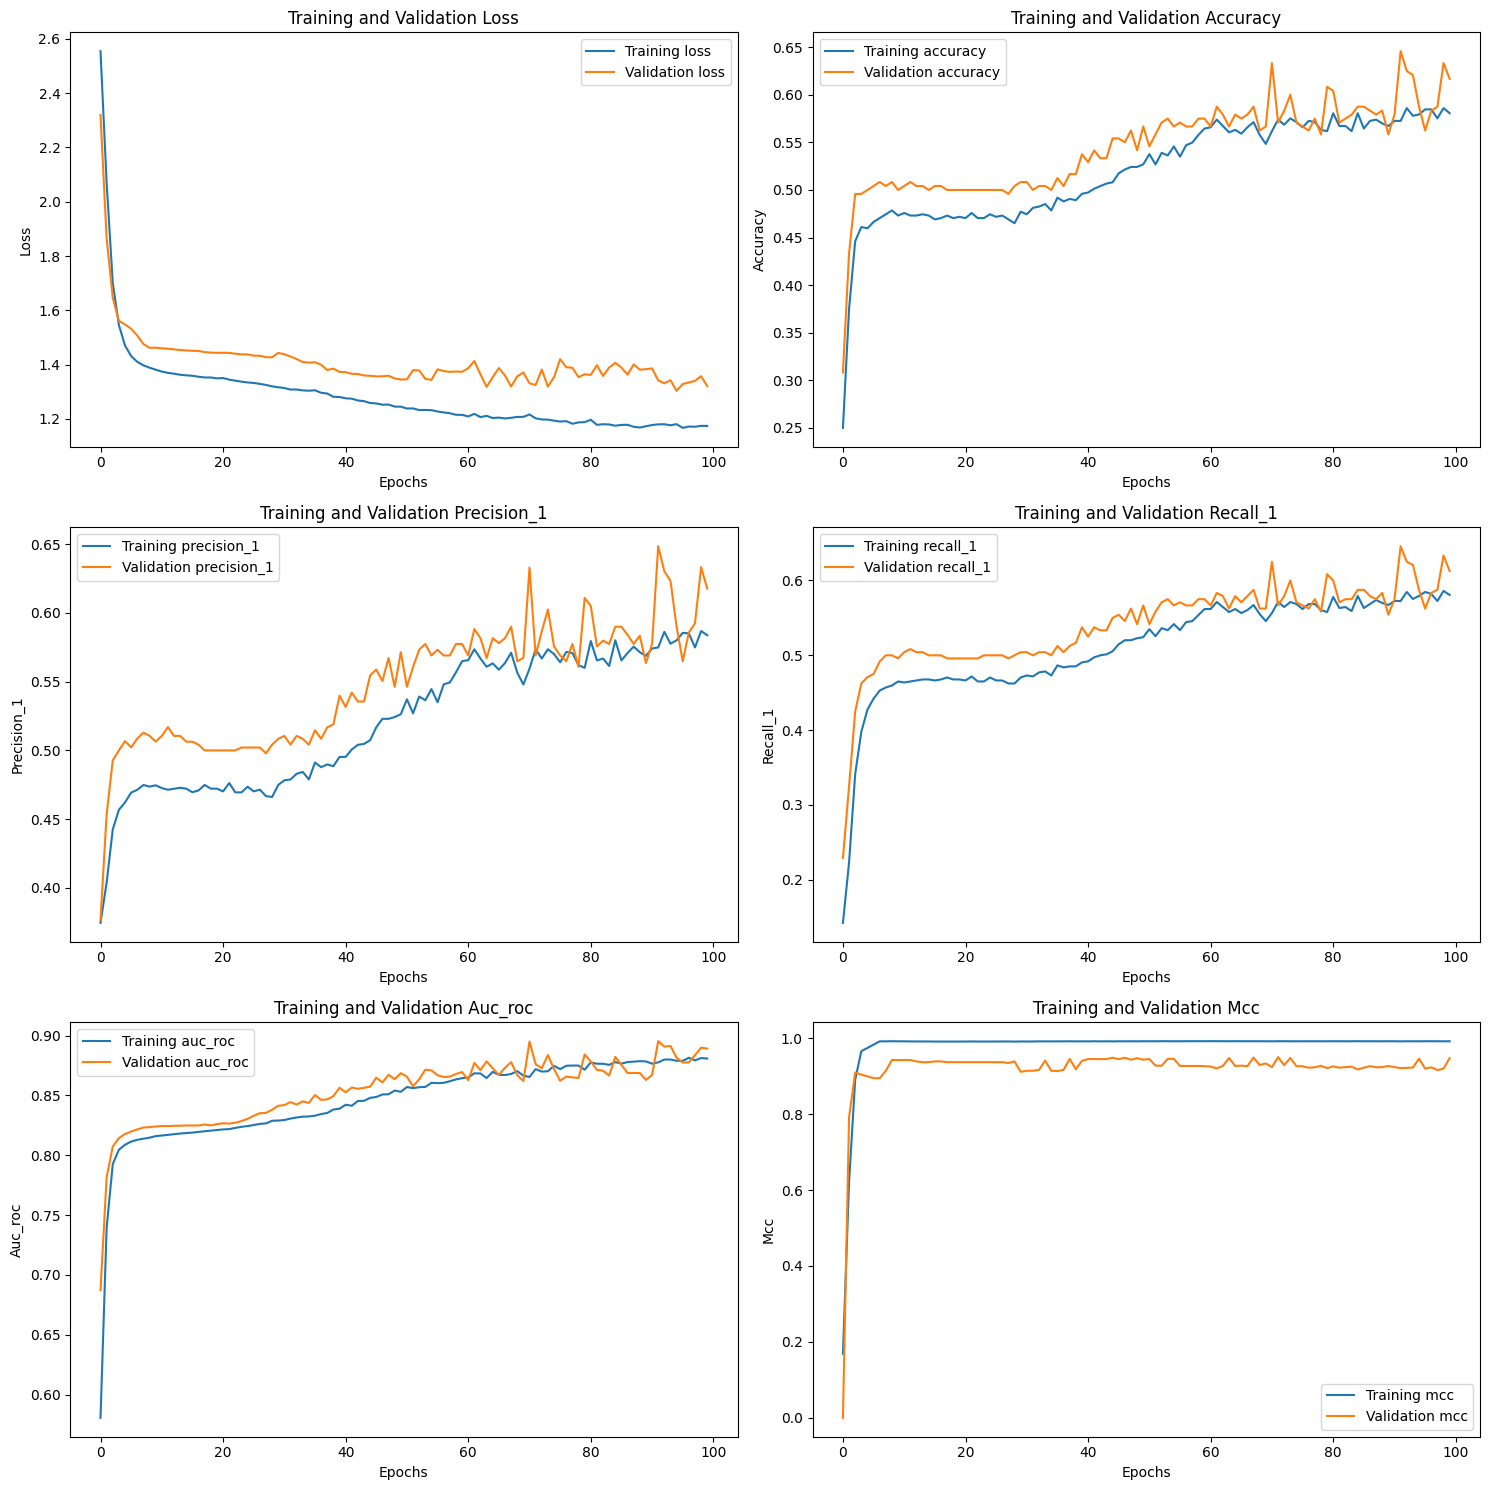

In [14]:
history_path = 'model_Google_100_epoch_DBT.pkl'

if os.path.exists(history_path):
    with open(history_path, 'rb') as f:
        history = pickle.load(f)
        print ("history cargado")
        
def plot_combined_history(history, columns=2):
    # Verifica si el historial es un objeto 'History' de Keras
    if hasattr(history, 'history'):
        history = history.history
    
    metrics = [key for key in history.keys() if not key.startswith('val_')]
    num_metrics = len(metrics)
    rows = (num_metrics + columns - 1) // columns  # Calcula el número de filas necesarias

    plt.figure(figsize=(15, 5 * rows))
    
    for i, metric in enumerate(metrics):
        plt.subplot(rows, columns, i + 1)
        plt.plot(history[metric], label=f'Training {metric}')
        plt.plot(history[f'val_{metric}'], label=f'Validation {metric}')
        plt.xlabel('Epochs')
        plt.ylabel(metric.capitalize())
        plt.title(f'Training and Validation {metric.capitalize()}')
        plt.legend()

    plt.tight_layout()
    plt.show()

# Puedes usar la función con un solo historial
plot_combined_history(history)

In [ ]:
model = tf.keras.models.load_model('model_Google_100_epoch_DBT.h5')

# Convertir etiquetas a one-hot encoding
def convert_to_one_hot(generator, num_classes):
    while True:
        for batch_images, batch_labels in generator:
            batch_labels_one_hot = tf.keras.utils.to_categorical(batch_labels, num_classes=num_classes)
            yield batch_images, batch_labels_one_hot


# Matriz de confusión
test_loss, test_accuracy = model.evaluate(test_generator_one_hot, steps=len(test_generator))
print(f"Loss: {test_loss}, Accuracy: {test_accuracy}")
y_pred_prob = model.predict(test_generator_one_hot, steps=len(test_generator))
y_pred = np.argmax(y_pred_prob, axis=1)


# Obtener las etiquetas verdaderas del conjunto de prueba
y_true = []
for _, labels in test_generator:
    y_true.extend(labels)
y_true = np.array(y_true)

# Asegurarse de que y_true esté en formato categórico
if len(y_true.shape) > 1 and y_true.shape[1] > 1:
    y_true = np.argmax(y_true, axis=1)


conf_matrix = confusion_matrix(y_true, y_pred)

labels = ['Actionable', 'Benign', 'Cancer', 'Normal']
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# model_Google_100_epoch_DBT_DA

In [ ]:
history_path = 'model_Google_100_epoch_DAug.pkl'

if os.path.exists(history_path):
    with open(history_path, 'rb') as f:
        history = pickle.load(f)
        print ("history cargado")

# Obtener las métricas de pérdida y precisión del historial de entrenamiento
train_loss = history.history['loss']
val_loss = history.history['val_loss']
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

# Google_100_epoch_607

In [ ]:
model = tf.keras.models.load_model('model_Google_100_epoch_607.h5')

# Convertir etiquetas a one-hot encoding
def convert_to_one_hot(generator, num_classes):
    while True:
        for batch_images, batch_labels in generator:
            batch_labels_one_hot = tf.keras.utils.to_categorical(batch_labels, num_classes=num_classes)
            yield batch_images, batch_labels_one_hot


# Matriz de confusión
test_loss, test_accuracy = model.evaluate(test_generator_one_hot, steps=len(test_generator))
print(f"Loss: {test_loss}, Accuracy: {test_accuracy}")
y_pred_prob = model.predict(test_generator_one_hot, steps=len(test_generator))
y_pred = np.argmax(y_pred_prob, axis=1)


# Obtener las etiquetas verdaderas del conjunto de prueba
y_true = []
for _, labels in test_generator:
    y_true.extend(labels)
y_true = np.array(y_true)

# Asegurarse de que y_true esté en formato categórico
if len(y_true.shape) > 1 and y_true.shape[1] > 1:
    y_true = np.argmax(y_true, axis=1)


conf_matrix = confusion_matrix(y_true, y_pred)

labels = ['Actionable', 'Benign', 'Cancer', 'Normal']
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
history_path = 'model_Google_100_epoch_607.pkl'

if os.path.exists(history_path):
    with open(history_path, 'rb') as f:
        history = pickle.load(f)
        print ("history cargado")

# Obtener las métricas de pérdida y precisión del historial de entrenamiento
train_loss = history.history['loss']
val_loss = history.history['val_loss']
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

# best_Google_DA_607

In [ ]:
model = tf.keras.models.load_model('best_model_Google_DA_607.h5')

# Convertir etiquetas a one-hot encoding
def convert_to_one_hot(generator, num_classes):
    while True:
        for batch_images, batch_labels in generator:
            batch_labels_one_hot = tf.keras.utils.to_categorical(batch_labels, num_classes=num_classes)
            yield batch_images, batch_labels_one_hot


# Matriz de confusión
test_loss, test_accuracy = model.evaluate(test_generator_one_hot, steps=len(test_generator))
print(f"Loss: {test_loss}, Accuracy: {test_accuracy}")
y_pred_prob = model.predict(test_generator_one_hot, steps=len(test_generator))
y_pred = np.argmax(y_pred_prob, axis=1)


# Obtener las etiquetas verdaderas del conjunto de prueba
y_true = []
for _, labels in test_generator:
    y_true.extend(labels)
y_true = np.array(y_true)

# Asegurarse de que y_true esté en formato categórico
if len(y_true.shape) > 1 and y_true.shape[1] > 1:
    y_true = np.argmax(y_true, axis=1)


conf_matrix = confusion_matrix(y_true, y_pred)

labels = ['Actionable', 'Benign', 'Cancer', 'Normal']
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
history_path = 'best_model_Google_DA_607.pkl'

if os.path.exists(history_path):
    with open(history_path, 'rb') as f:
        history = pickle.load(f)
        print ("history cargado")

# Obtener las métricas de pérdida y precisión del historial de entrenamiento
train_loss = history['loss']
val_loss = history['val_loss']
train_acc = history['accuracy']
val_acc = history['val_accuracy']

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()